
Rosenbrock: 5D


In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=b4d2ddecfe3f0c5e1fa72803d93c0d45e01c819f8ff86efc55a6d99cf601c0e3
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Rosenbrock'
Beta_CBM = 1.5 # Default UCB Acquisition function parameter in pyGPGO https://github.com/josejimenezluna/pyGPGO/blob/master/pyGPGO/acquisition.py#L83
n_test = 500
eps = 1e-08

util_grad_exact = 'dCBM_GP'
util_grad_approx = 'CBM'

n_init = 5 # random initialisations
iters = 50
opt = True

In [4]:
### Objective Function - Rosenbrock(x) 5-D:

def objfunc(x1_training, x2_training, x3_training, x4_training, x5_training):
            return  operator * (
                100 * (x2_training - x1_training ** 2) ** 2 + (x1_training - 1) ** 2 + 
                100 * (x3_training - x2_training ** 2) ** 2 + (x2_training - 1) ** 2 +
                100 * (x4_training - x3_training ** 2) ** 2 + (x3_training - 1) ** 2 +
                100 * (x5_training - x4_training ** 2) ** 2 + (x4_training - 1) ** 2
                )
        
# Constraints:
lb = -2.048
ub = +2.048
    
# Input array dimension(s):
dim = 5

# 5-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub]),
                 'x3_training': ('cont', [lb, ub]),
                 'x4_training': ('cont', [lb, ub]),
                 'x5_training': ('cont', [lb, ub])}
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x3_test = np.linspace(lb, ub, n_test)
x4_test = np.linspace(lb, ub, n_test)
x5_test = np.linspace(lb, ub, n_test)

Xstar = np.column_stack((x1_test, x2_test, x3_test, x4_test, x5_test))


In [5]:
n_start_AcqFunc = iters


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM,
            'dCBM_GP': self.dCBM_GP
        }

        self.f = mode_dict[mode]

    def CBM(self, tau, mean, std):
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (z + np.sqrt(Beta_CBM))

    def dCBM_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max AcqFunc.'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        
        self.history.append(self.f_best_min)
          
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], self.GP.y[init_eval], self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(self.GP.y[-1])
        curr_best = str(self.tau)
        max_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + str(self.f_best_min) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max AcqFunc.'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], self.GP.y[init_eval], self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(self.GP.y[-1])
        curr_best = str(self.tau)
        max_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + str(self.f_best_min) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1649238115.3308785

In [13]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_new(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.33987787  0.90244913 -2.04753152 -0.80964578 -1.44688787]	 -3839.412791563609	 -1472.9896042463429	    
init	 [-1.66978112 -1.28507817 -0.63258326 -0.42284043  0.15899334]	 -2265.615579017705	 -1472.9896042463429	    
init	 [-0.33097927  0.75865907 -1.21056359  1.54876902 -1.93582042]	 -2247.6652349539345	 -1472.9896042463429	    
init	 [ 0.69823492 -0.33871953  0.24039354 -1.4729751  -1.2365763 ]	 -1472.9896042463429	 -1472.9896042463429	    
init	 [ 1.23184975  1.91799941 -0.76421457  0.78775343  1.54168997]	 -2083.0654180168144	 -1472.9896042463429	    
1  	 [ 2.048 -2.048  2.048  2.048  2.048]	 -5291.207396966399	 -1472.9896042463429	 -2.446998935229919
2  	 [-2.048  2.048  2.048 -2.048  2.048]	 -5299.399396966399	 -1472.9896042463429	 -2.4422649023032927
3  	 [ 2.048 -2.048 -2.048 -2.048  2.048]	 -12179.5390705664	 -1472.9896042463429	 -2.4132703804560167
4  	 [-2.048 -2.048  2.048  2.048 -

In [14]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_new(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.26216488 -1.94180615  0.20341751 -0.26491948 -0.32617348]	 -1714.2862725787786	 -770.3222673828897	    
init	 [-0.69494857 -1.20975919  0.48853388 -0.82061446 -0.95507548]	 -770.3222673828897	 -770.3222673828897	    
init	 [ 0.49616418  0.11936602 -1.49676054  0.05561598 -1.29253431]	 -883.2239805423782	 -770.3222673828897	    
init	 [ 1.16873277  1.4498828  -0.02360591  1.41951584 -1.72177213]	 -2051.757258489535	 -770.3222673828897	    
init	 [ 0.02148799 -1.78058648 -0.29441095 -1.65260937 -1.52715276]	 -3650.965608581488	 -770.3222673828897	    
1  	 [-2.048       1.18610727  2.048      -1.15238976 -0.83748034]	 -4288.732908771024	 -770.3222673828897	 -2.4914088457596835
2  	 [-2.048  2.048 -2.048  2.048  2.048]	 -5299.399396966399	 -770.3222673828897	 -2.447926070870582
3  	 [ 2.048       2.048       0.86879659 -2.048       2.048     ]	 -2824.301247225389	 -770.3222673828897	 -2.44622541383

In [15]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_new(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 0.20806821  0.85257348 -0.85645419  0.04434987  1.60951073]	 -627.1117741979103	 -622.484535903532	    
init	 [ 1.62321649 -1.53360257 -1.19913317 -1.83719034 -0.24244288]	 -5399.706136296182	 -622.484535903532	    
init	 [-1.92562704 -0.17681111  0.61089402 -0.90731609  0.72194008]	 -1721.5329533113518	 -622.484535903532	    
init	 [ 0.3721741  -1.94977021  0.24106634 -0.98610198 -0.3477455 ]	 -2000.7676879852984	 -622.484535903532	    
init	 [-0.88668127  0.79109291 -0.24390157 -1.40546974  0.18288238]	 -622.484535903532	 -622.484535903532	    
1  	 [ 2.048  2.048  2.048  2.048 -2.048]	 -5283.0153969664	 -622.484535903532	 -2.4493648296921697
2  	 [-2.048  2.048 -2.048  2.048 -2.048]	 -8735.373233766397	 -622.484535903532	 -2.4457371141595354
3  	 [ 2.048 -2.048  2.048  2.048  2.048]	 -5291.207396966399	 -622.484535903532	 -2.424007153118972
4  	 [-2.048 -2.048  2.048  2.048 -2.048]	 -8735.37323

In [16]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition_new(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.91295422 0.19346329 1.93611514 0.87988631 0.80989727]	 -2387.189335089887	 -2094.3025257407685	    
init	 [-1.16289743  1.95082017 -2.02248087 -1.01178424 -0.26709388]	 -6221.226958170779	 -2094.3025257407685	    
init	 [ 1.14435245 -1.23828193  1.48682029  1.98000917 -1.37690218]	 -3467.083865224009	 -2094.3025257407685	    
init	 [ 0.39867983 -2.01119294 -0.46460403 -1.8671204   1.87045056]	 -3219.228680406749	 -2094.3025257407685	    
init	 [-0.26154333  1.83901105  1.17270932  1.50032097 -1.33871443]	 -2094.3025257407685	 -2094.3025257407685	    
1  	 [-2.048 -2.048  2.048 -2.048 -2.048]	 -12179.539070566398	 -2094.3025257407685	 -2.4462307575290945
2  	 [-2.048 -2.048 -2.048  2.048  2.048]	 -8743.5652337664	 -2094.3025257407685	 -2.4383568120174415
3  	 [-2.048  2.048  2.048 -2.048  2.048]	 -5299.399396966399	 -2094.3025257407685	 -2.425752969097305
4  	 [ 2.048  2.048 -2.048  2.048  2.048]	

In [17]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_new(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.13871597  1.51851953 -1.20127834  1.71463028 -0.04746777]	 -2144.9971005556176	 -249.97815145665106	    
init	 [ 0.45770286  1.08915858  0.07544008 -0.83230515 -1.27909385]	 -664.3224967570579	 -249.97815145665106	    
init	 [-1.71728376  0.97665145 -0.24039742 -1.39956278  1.55622208]	 -774.9367743037218	 -249.97815145665106	    
init	 [-0.92534185 -0.35129336 -0.8352566   0.52751527  0.32701567]	 -249.97815145665106	 -249.97815145665106	    
init	 [ 0.40930999 -0.95920489 -0.88192663 -1.00930271 -0.70629807]	 -1080.3719207817278	 -249.97815145665106	    
1  	 [ 2.048 -2.048  2.048  2.048  2.048]	 -5291.207396966399	 -249.97815145665106	 -2.4490523031845868
2  	 [-2.048 -2.048  2.048  2.048 -2.048]	 -8735.373233766397	 -249.97815145665106	 -2.445258877754825
3  	 [ 2.048  2.048  2.048 -2.048  2.048]	 -5291.207396966399	 -249.97815145665106	 -2.4245211541581058
4  	 [ 2.048  2.048  2.048  2.048 

In [18]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_new(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.60915518 -0.68821072  1.31575449 -1.87721062 -1.60703824]	 -5091.519009229838	 -79.69342767466901	    
init	 [ 0.38933325  0.12213192 -0.33256477 -0.67416945  0.50183959]	 -79.69342767466901	 -79.69342767466901	    
init	 [-0.25337272  0.96617311  0.07387714  0.32300483  0.59537447]	 -192.33344733824742	 -79.69342767466901	    
init	 [ 2.00795862  1.31013917 -0.35552897  1.54119232  1.32611864]	 -1483.5914121862702	 -79.69342767466901	    
init	 [-1.82487242  0.89553812  1.23769062  0.96832161  0.85660365]	 -652.1863814079042	 -79.69342767466901	    
1  	 [-2.048 -2.048 -2.048  2.048 -2.048]	 -12179.5390705664	 -79.69342767466901	 -2.449212795353125
2  	 [-2.048  2.048 -2.048 -2.048 -2.048]	 -12179.539070566398	 -79.69342767466901	 -2.446878452045565
3  	 [-2.048 -2.048 -2.048 -2.048  2.048]	 -12187.731070566399	 -79.69342767466901	 -2.4458461876084088
4  	 [ 0.90562491 -2.048       2.048       

In [19]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_new(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.73544125  1.14654737 -0.25227579  0.91531337  1.95784504]	 -800.4654116124435	 -800.4654116124435	    
init	 [ 1.57679085e-01  4.58941915e-03 -1.75287856e+00 -9.48473938e-01
 -4.81276619e-04]	 -2018.287263705002	 -800.4654116124435	    
init	 [ 0.73412606  1.24411509 -0.48766512 -1.77792472 -0.86775563]	 -2503.5301785370166	 -800.4654116124435	    
init	 [ 1.67769509 -1.17397359 -0.19610025  1.76621986 -1.94601276]	 -4710.462155417455	 -800.4654116124435	    
init	 [ 0.41184837  1.84373043 -1.10467941  0.19861471  1.67578982]	 -2687.1643805365006	 -800.4654116124435	    
1  	 [ 2.048 -2.048  2.048 -2.048  2.048]	 -8735.373233766399	 -800.4654116124435	 -2.4471784347499717
2  	 [-2.048 -2.048  2.048 -2.048 -2.048]	 -12179.539070566398	 -800.4654116124435	 -2.446526692034134
3  	 [-2.048  2.048  2.048  2.048 -2.048]	 -5291.2073969664	 -800.4654116124435	 -2.444969275484665
4  	 [-2.048      -2.048

In [20]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_new(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.52956683  1.91914255  1.51222084  0.12638491 -1.09474477]	 -1081.2162150439515	 -124.94179932476796	    
init	 [-2.0013105  -0.28479972 -0.39996883  0.09287545 -0.0885072 ]	 -1878.4261119736025	 -124.94179932476796	    
init	 [0.22674012 0.17770913 1.06862828 0.86988626 0.49021787]	 -124.94179932476796	 -124.94179932476796	    
init	 [-0.30272811 -0.86394869  1.94091107 -0.68086151 -1.15179085]	 -2482.289555085358	 -124.94179932476796	    
init	 [-1.77844884  1.97783776 -1.524303   -0.72855227 -1.75741811]	 -4568.726977792538	 -124.94179932476796	    
1  	 [ 2.048 -2.048 -2.048 -2.048  2.048]	 -12179.5390705664	 -124.94179932476796	 -2.4492972837827285
2  	 [ 2.048 -2.048 -2.048  2.048 -2.048]	 -12171.347070566397	 -124.94179932476796	 -2.448531934455835
3  	 [ 2.048  2.048 -2.048  2.048  2.048]	 -5291.207396966399	 -124.94179932476796	 -2.446563522517099
4  	 [-2.048  2.048  2.048 -2.048  2.048

In [21]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_new(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.00550747  0.00767833 -0.01731259 -1.49983425 -1.46591299]	 -3234.32985531406	 -698.816697067542	    
init	 [-1.15278366 -0.33379049 -1.03177761 -1.70369167 -0.63283757]	 -2441.2299512519935	 -698.816697067542	    
init	 [-1.36488408  1.55057801  1.84714867 -1.88928665  0.81554388]	 -3624.451688475595	 -698.816697067542	    
init	 [0.2980242  1.63023716 0.68361819 0.19594356 0.82914273]	 -698.816697067542	 -698.816697067542	    
init	 [-0.46498951  0.79642082  1.33066942 -0.14062192  1.80438798]	 -769.5492682487568	 -698.816697067542	    
1  	 [ 2.048 -2.048  2.048  2.048 -2.048]	 -8727.181233766398	 -698.816697067542	 -2.4493835541485165
2  	 [ 2.048 -2.048 -2.048  2.048  2.048]	 -8735.373233766399	 -698.816697067542	 -2.4490266901212614
3  	 [ 2.048  2.048 -2.048  2.048 -2.048]	 -8727.181233766398	 -698.816697067542	 -2.444885787441567
4  	 [ 2.048 -2.048  2.048 -2.048  2.048]	 -8735.3732337663

In [22]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_new(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.11132935 -1.96300002  0.54742317  1.0191007  -0.00611528]	 -2285.5727395941803	 -850.951970378683	    
init	 [-1.12723294 -1.23673451  1.0671338  -1.35532201 -1.68616012]	 -2528.4047405486313	 -850.951970378683	    
init	 [ 0.75923382  1.85709915 -2.0318279   0.04993951  1.28049546]	 -5005.295403630435	 -850.951970378683	    
init	 [ 0.46090677  0.90830978 -0.85247562  1.71120281  0.87890241]	 -850.951970378683	 -850.951970378683	    
init	 [ 0.17426173 -1.46567149 -0.51879625  0.71325129 -0.23825132]	 -1019.7669744480771	 -850.951970378683	    
1  	 [-2.048  2.048  2.048 -2.048  2.048]	 -5299.399396966399	 -850.951970378683	 -2.4467730070558003
2  	 [-2.048  2.048  2.048  2.048 -2.048]	 -5291.2073969664	 -850.951970378683	 -2.4410246833251446
3  	 [ 2.048  2.048  2.048 -2.048 -2.048]	 -8727.1812337664	 -850.951970378683	 -2.432102475090238
4  	 [-2.048 -2.048 -2.048 -2.048  2.048]	 -12187.73107

In [23]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_new(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.30961535 -1.96822941 -0.15065692  0.92132937 -0.32684604]	 -3210.8679550302345	 -1144.865751233045	    
init	 [-0.05969061 -1.99564978 -0.0517259   1.80964005  1.43685669]	 -2703.451344055813	 -1144.865751233045	    
init	 [ 0.94193447 -1.60261705  1.61343148  1.4629038  -1.37180521]	 -2081.857323444205	 -1144.865751233045	    
init	 [ 0.54204012 -1.96409912 -1.56984415 -0.75215949 -1.40119119]	 -4895.80736778237	 -1144.865751233045	    
init	 [ 1.06078039  1.30365587 -0.63641809 -0.74220013 -1.59063559]	 -1144.865751233045	 -1144.865751233045	    
1  	 [-2.048  2.048  2.048 -2.048  2.048]	 -5299.399396966399	 -1144.865751233045	 -2.449409978675599
2  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -1144.865751233045	 -2.4440378195679395
3  	 [-2.048  2.048 -2.048  2.048  2.048]	 -5299.399396966399	 -1144.865751233045	 -2.4417609248107977
4  	 [ 2.048 -2.048  2.048 -2.048  2.048]	 -8735.373

In [24]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_new(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.416549    0.98324356 -0.9694617   0.13819656 -1.98830095]	 -957.3190374857435	 -801.6353027590994	    
init	 [ 1.71518775  1.64132804 -1.91110583  1.87166448 -1.48599062]	 -5106.164621714079	 -801.6353027590994	    
init	 [-0.88543907  0.43451672  1.81954616  1.44480478 -2.03874618]	 -2333.6228529468017	 -801.6353027590994	    
init	 [ 0.08694181  0.21314615 -0.05989411  1.0982775  -1.38970418]	 -801.6353027590994	 -801.6353027590994	    
init	 [ 1.0836396  -1.96276307 -1.49417911 -1.57174572 -0.77865949]	 -6367.264281228379	 -801.6353027590994	    
1  	 [ 2.048  2.048  2.048 -2.048  2.048]	 -5291.207396966399	 -801.6353027590994	 -2.4494489216046835
2  	 [-2.048 -2.048  2.048 -2.048  2.048]	 -8743.565233766398	 -801.6353027590994	 -2.448603624022356
3  	 [ 2.048 -2.048  2.048  2.048  2.048]	 -5291.207396966399	 -801.6353027590994	 -2.4482107667017856
4  	 [-2.048 -2.048 -2.048  2.048  2.048]	 -

In [25]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_new(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.13746907 -1.07503116  1.32824487  1.90770872  1.93577416]	 -861.6633106396614	 -185.99917172797404	    
init	 [-0.19067188  0.44663793  1.1285566   0.58004826  0.90938667]	 -185.99917172797404	 -185.99917172797404	    
init	 [-1.9044904  -0.82555097 -1.80833283  1.46252162 -0.5207899 ]	 -3656.563030891297	 -185.99917172797404	    
init	 [ 0.73665721 -0.99827733 -0.62430734 -2.00944529 -0.58026483]	 -3224.263616417716	 -185.99917172797404	    
init	 [ 1.83948977 -1.15548566 -0.73977296  1.71119569 -1.91732258]	 -4983.227555400366	 -185.99917172797404	    
1  	 [-2.048  2.048  2.048 -2.048 -2.048]	 -8735.373233766399	 -185.99917172797404	 -2.4452863231931783
2  	 [-2.048  2.048 -2.048 -2.048  2.048]	 -8743.5652337664	 -185.99917172797404	 -2.4429131642283375
3  	 [ 2.048  2.048 -2.048  2.048  2.048]	 -5291.207396966399	 -185.99917172797404	 -2.4373145053221794
4  	 [-2.048 -2.048  2.048 -2.048  2.

In [26]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_new(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 0.05711194  1.11888405  1.5172718  -2.0150397  -0.77932165]	 -4347.822046340615	 -1409.8005009363899	    
init	 [ 1.87434492  0.05372605 -0.744307    0.16056294 -1.14173976]	 -1409.8005009363899	 -1409.8005009363899	    
init	 [ 1.25534764 -0.64612505  0.15928873 -2.02394097  0.70923255]	 -2080.2470418722683	 -1409.8005009363899	    
init	 [-1.18774062  1.7717559  -0.51509351  1.0339079   1.07781735]	 -1415.1198561115807	 -1409.8005009363899	    
init	 [ 1.51756577 -1.59698461 -0.81882325 -0.10278598  0.7083488 ]	 -2776.1514541695005	 -1409.8005009363899	    
1  	 [-2.048 -2.048  2.048  2.048 -2.048]	 -8735.373233766397	 -1409.8005009363899	 -2.4491207992590445
2  	 [-2.048 -2.048 -2.048 -2.048 -2.048]	 -15623.704907366397	 -1409.8005009363899	 -2.4407911134941656
3  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -1409.8005009363899	 -2.3947005460647115
4  	 [-2.048 -2.048 -2.048  2.048  2.0

In [27]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_new(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.42875729 -1.31524229 -1.82532827 -0.56713852 -0.9199578 ]	 -4080.938364892878	 -1666.3245658099584	    
init	 [ 0.12288092 -0.79495612 -0.80087302 -1.59030773 -1.02441364]	 -2045.6444118558318	 -1666.3245658099584	    
init	 [ 1.71061206 -0.96605449  0.89200102  1.49796878  1.25779756]	 -1666.3245658099584	 -1666.3245658099584	    
init	 [-1.18558481 -1.36297254 -1.85669062 -1.88652621 -1.2278546 ]	 -7309.374150449582	 -1666.3245658099584	    
init	 [ 2.04203378 -0.52106454  1.06705008 -0.10864868  0.03979389]	 -2424.078646287884	 -1666.3245658099584	    
1  	 [-2.048  2.048 -2.048  2.048  2.048]	 -5299.399396966399	 -1666.3245658099584	 -2.449404486723216
2  	 [-2.048  2.048  2.048  2.048 -2.048]	 -5291.2073969664	 -1666.3245658099584	 -2.449257971189992
3  	 [-2.048  2.048  2.048 -2.048  2.048]	 -5299.399396966399	 -1666.3245658099584	 -2.4489436033151737
4  	 [ 2.048  2.048 -2.048 -2.048  2.0

In [28]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_new(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.13339974  0.09487705  0.20767317 -1.86121441 -0.57045469]	 -2150.105497323624	 -464.3305193395537	    
init	 [-1.13426046  0.77302236 -1.37735608 -1.75994935  1.80638048]	 -1938.3641131025609	 -464.3305193395537	    
init	 [ 0.26083893 -1.72854338  0.91193553 -1.3989799  -1.02284777]	 -2153.0674066382217	 -464.3305193395537	    
init	 [-0.8458762   0.80531749 -0.1463743  -1.16710546 -0.21779963]	 -464.3305193395537	 -464.3305193395537	    
init	 [-1.55288063  1.71084598  0.27216416 -0.11460888 -0.75953592]	 -825.9518535108758	 -464.3305193395537	    
1  	 [ 2.048 -2.048 -2.048  2.048  2.048]	 -8735.373233766399	 -464.3305193395537	 -2.4493687565696156
2  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -464.3305193395537	 -2.4490638356694876
3  	 [-2.048 -2.048  2.048  2.048  2.048]	 -5299.399396966399	 -464.3305193395537	 -2.4480526739709765
4  	 [ 2.048  2.048 -2.048  2.048 -2.048]	 -8727.

In [29]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_new(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.84105215  0.12528335 -1.26353086 -1.76988013  1.17549244]	 -1730.7116065995144	 -102.96374117512207	    
init	 [ 0.64034211  0.56328559  0.30966945 -1.8879983  -0.58239548]	 -2124.78014520564	 -102.96374117512207	    
init	 [ 1.82551833 -1.80205699  1.49111646  1.545382   -1.83831075]	 -4786.2319677829355	 -102.96374117512207	    
init	 [ 0.62430665  0.21197361  0.39941429 -0.06746675 -0.88888049]	 -102.96374117512207	 -102.96374117512207	    
init	 [-0.82851546  0.25194048 -0.4257897   1.18251811 -0.33388796]	 -449.09485578988813	 -102.96374117512207	    
1  	 [2.048      2.048      2.048      1.98290814 2.048     ]	 -1769.529583583629	 -102.96374117512207	 -2.448615936975076
2  	 [ 2.048 -2.048 -2.048  2.048  2.048]	 -8735.373233766399	 -102.96374117512207	 -2.444369079148974
3  	 [-2.048 -2.048  2.048  2.048  2.048]	 -5299.399396966399	 -102.96374117512207	 -2.4343345691691174
4  	 [ 2.048  2

In [30]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_new(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 0.61593289  0.02233702  1.55075162 -1.30318244  1.44274665]	 -1641.2531670470794	 -1071.5524917602852	    
init	 [ 1.02455823  0.68035243  1.99841976 -0.99545734 -1.93205893]	 -3598.053283618411	 -1071.5524917602852	    
init	 [ 0.5559055   1.42259154  0.96737126 -1.96277407 -1.59087358]	 -4047.9431145207936	 -1071.5524917602852	    
init	 [-0.82852355  0.7658299   1.48122033 -1.23439366  0.64384627]	 -1342.1225903342352	 -1071.5524917602852	    
init	 [ 0.81778946 -0.60460045  1.1876784   1.28634035 -1.23936242]	 -1071.5524917602852	 -1071.5524917602852	    
1  	 [-2.048 -2.048 -2.048  2.048  2.048]	 -8743.5652337664	 -1071.5524917602852	 -2.449406119972249
2  	 [ 2.048  2.048 -2.048  2.048  2.048]	 -5291.207396966399	 -1071.5524917602852	 -2.4489538411688083
3  	 [-2.048  2.048 -2.048  2.048 -2.048]	 -8735.373233766397	 -1071.5524917602852	 -2.448196370000009
4  	 [-2.048 -2.048 -2.048 -2.048 -2

In [31]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_new(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.64850237  1.07007884 -1.03654206 -1.48221261 -0.69039488]	 -2252.0055801004173	 -626.7075296149584	    
init	 [-1.70803378  0.70441812  1.2558082   1.97731088  0.55566637]	 -1696.8746906482318	 -626.7075296149584	    
init	 [-1.16357834  0.20081636  0.18661359 -1.0892244  -1.58217895]	 -1038.3067280640882	 -626.7075296149584	    
init	 [-1.39564217e-03 -1.42496390e+00  1.33882186e-01 -4.62820276e-01
  7.71388962e-01]	 -626.7075296149584	 -626.7075296149584	    
init	 [-0.52049037  1.82747154  1.13605803  0.44250851  0.47199042]	 -810.7549654192183	 -626.7075296149584	    
1  	 [ 2.048  2.048 -2.048  2.048 -2.048]	 -8727.181233766398	 -626.7075296149584	 -2.4479005280741823
2  	 [ 2.048 -2.048  2.048  2.048 -2.048]	 -8727.181233766398	 -626.7075296149584	 -2.444553423114227
3  	 [ 2.048  2.048 -2.048 -2.048  2.048]	 -8735.3732337664	 -626.7075296149584	 -2.4383364434597365
4  	 [-2.048 -2.048 -2.

In [32]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_new(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 0.36098376  1.62903543  1.60370987  1.29367031 -1.90099626]	 -1777.2774780852724	 -104.43212504231103	    
init	 [ 0.78543905 -0.49692286  0.07582083  0.6469692  -1.25398951]	 -451.1184424124108	 -104.43212504231103	    
init	 [-0.93259202  0.8954099   1.15918278  1.43494201  1.12740309]	 -104.43212504231103	 -104.43212504231103	    
init	 [-1.897823   -1.57002246  1.02924575 -1.06816219 -1.00431457]	 -3812.9699104482297	 -104.43212504231103	    
init	 [ 1.46483418  1.84229489  0.25266937 -1.31571499  1.10695192]	 -1232.1564521052503	 -104.43212504231103	    
1  	 [-2.048 -2.048 -2.048  2.048  2.048]	 -8743.5652337664	 -104.43212504231103	 -2.4470773992604737
2  	 [-2.048  2.048 -2.048 -2.048 -2.048]	 -12179.539070566398	 -104.43212504231103	 -2.439956921658875
3  	 [ 1.5676953  -1.29657279 -1.76711993 -0.66387569  0.69665799]	 -4054.852654219339	 -104.43212504231103	 -2.4494900512168254
4  	 [ 2.

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1649239905.8496091

In [34]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.33987787  0.90244913 -2.04753152 -0.80964578 -1.44688787]	 -3839.412791563609	 -1472.9896042463429	    
init	 [-1.66978112 -1.28507817 -0.63258326 -0.42284043  0.15899334]	 -2265.615579017705	 -1472.9896042463429	    
init	 [-0.33097927  0.75865907 -1.21056359  1.54876902 -1.93582042]	 -2247.6652349539345	 -1472.9896042463429	    
init	 [ 0.69823492 -0.33871953  0.24039354 -1.4729751  -1.2365763 ]	 -1472.9896042463429	 -1472.9896042463429	    
init	 [ 1.23184975  1.91799941 -0.76421457  0.78775343  1.54168997]	 -2083.0654180168144	 -1472.9896042463429	    
1	 [ 1.0228798  -1.02610926  2.048       1.20494682  2.048     ]	 -1462.908842353896	 -1462.908842353896	 -2.1938673294699376
2  	 [ 1.76890313  1.78941289  1.41037547  1.72116588 -1.11452041]	 -2171.6682574563324	 -1462.908842353896	 0.9363391850074936
3  	 [ 2.00433687 -1.72968112 -0.72855751  1.82744021 -2.01138544]	 -7730.457894723466	 -14

In [35]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.26216488 -1.94180615  0.20341751 -0.26491948 -0.32617348]	 -1714.2862725787786	 -770.3222673828897	    
init	 [-0.69494857 -1.20975919  0.48853388 -0.82061446 -0.95507548]	 -770.3222673828897	 -770.3222673828897	    
init	 [ 0.49616418  0.11936602 -1.49676054  0.05561598 -1.29253431]	 -883.2239805423782	 -770.3222673828897	    
init	 [ 1.16873277  1.4498828  -0.02360591  1.41951584 -1.72177213]	 -2051.757258489535	 -770.3222673828897	    
init	 [ 0.02148799 -1.78058648 -0.29441095 -1.65260937 -1.52715276]	 -3650.965608581488	 -770.3222673828897	    
1  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -770.3222673828897	 -2.4039075102824876
2  	 [-1.54502691  1.36774745  1.86963011 -1.25500671  2.04698239]	 -2395.3835665083075	 -770.3222673828897	 -2.436242783669924
3  	 [-2.048       0.55471339 -2.048      -2.048       0.5400877 ]	 -7139.632293940853	 -770.3222673828897	 -1.7464687902375122


In [36]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 0.20806821  0.85257348 -0.85645419  0.04434987  1.60951073]	 -627.1117741979103	 -622.484535903532	    
init	 [ 1.62321649 -1.53360257 -1.19913317 -1.83719034 -0.24244288]	 -5399.706136296182	 -622.484535903532	    
init	 [-1.92562704 -0.17681111  0.61089402 -0.90731609  0.72194008]	 -1721.5329533113518	 -622.484535903532	    
init	 [ 0.3721741  -1.94977021  0.24106634 -0.98610198 -0.3477455 ]	 -2000.7676879852984	 -622.484535903532	    
init	 [-0.88668127  0.79109291 -0.24390157 -1.40546974  0.18288238]	 -622.484535903532	 -622.484535903532	    
1  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -622.484535903532	 -2.400425883344559
2  	 [-2.048       0.50951216 -2.048       0.43258726 -2.00136912]	 -3803.4201092045214	 -622.484535903532	 -1.8699248063654144
3  	 [ 2.01143268  1.03171315 -0.84558666  1.75079347 -1.29365714]	 -3285.634691033429	 -622.484535903532	 -2.040506049333672
4  	 [ 1.

In [37]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.91295422 0.19346329 1.93611514 0.87988631 0.80989727]	 -2387.189335089887	 -2094.3025257407685	    
init	 [-1.16289743  1.95082017 -2.02248087 -1.01178424 -0.26709388]	 -6221.226958170779	 -2094.3025257407685	    
init	 [ 1.14435245 -1.23828193  1.48682029  1.98000917 -1.37690218]	 -3467.083865224009	 -2094.3025257407685	    
init	 [ 0.39867983 -2.01119294 -0.46460403 -1.8671204   1.87045056]	 -3219.228680406749	 -2094.3025257407685	    
init	 [-0.26154333  1.83901105  1.17270932  1.50032097 -1.33871443]	 -2094.3025257407685	 -2094.3025257407685	    
1  	 [-2.048 -2.048 -2.048 -2.048 -2.048]	 -15623.704907366397	 -2094.3025257407685	 -2.3541911008875043
2  	 [-0.71916917 -1.99917024 -1.77025778  1.8910191  -0.10269871]	 -5487.093523882751	 -2094.3025257407685	 -1.683312587042713
3  	 [ 0.81276114  1.41443635  1.829968   -1.78330707 -1.88334964]	 -5266.156956706989	 -2094.3025257407685	 -0.4401734

In [38]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.13871597  1.51851953 -1.20127834  1.71463028 -0.04746777]	 -2144.9971005556176	 -249.97815145665106	    
init	 [ 0.45770286  1.08915858  0.07544008 -0.83230515 -1.27909385]	 -664.3224967570579	 -249.97815145665106	    
init	 [-1.71728376  0.97665145 -0.24039742 -1.39956278  1.55622208]	 -774.9367743037218	 -249.97815145665106	    
init	 [-0.92534185 -0.35129336 -0.8352566   0.52751527  0.32701567]	 -249.97815145665106	 -249.97815145665106	    
init	 [ 0.40930999 -0.95920489 -0.88192663 -1.00930271 -0.70629807]	 -1080.3719207817278	 -249.97815145665106	    
1  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -249.97815145665106	 -2.4457966329452585
2  	 [-2.048 -2.048 -2.048 -2.048 -2.048]	 -15623.704907366397	 -249.97815145665106	 -0.7250044415964586
3  	 [-1.99676445  0.13794787  1.93738899  1.20298598 -1.76568081]	 -3542.971091812827	 -249.97815145665106	 -1.7596179880271785
4  	 [ 1.61228

In [39]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.60915518 -0.68821072  1.31575449 -1.87721062 -1.60703824]	 -5091.519009229838	 -79.69342767466901	    
init	 [ 0.38933325  0.12213192 -0.33256477 -0.67416945  0.50183959]	 -79.69342767466901	 -79.69342767466901	    
init	 [-0.25337272  0.96617311  0.07387714  0.32300483  0.59537447]	 -192.33344733824742	 -79.69342767466901	    
init	 [ 2.00795862  1.31013917 -0.35552897  1.54119232  1.32611864]	 -1483.5914121862702	 -79.69342767466901	    
init	 [-1.82487242  0.89553812  1.23769062  0.96832161  0.85660365]	 -652.1863814079042	 -79.69342767466901	    
1  	 [-2.048 -2.048 -2.048 -2.048 -2.048]	 -15623.704907366397	 -79.69342767466901	 -2.445194690795934
2  	 [-0.4700094  -1.6121876  -2.00669194  1.62258952  0.68823197]	 -3431.9755222788867	 -79.69342767466901	 -2.1037410670815566
3  	 [ 1.62942602 -1.83471509  0.89839433  1.7460557  -0.83008059]	 -4226.438873102403	 -79.69342767466901	 -0.08706793

In [40]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.73544125  1.14654737 -0.25227579  0.91531337  1.95784504]	 -800.4654116124435	 -800.4654116124435	    
init	 [ 1.57679085e-01  4.58941915e-03 -1.75287856e+00 -9.48473938e-01
 -4.81276619e-04]	 -2018.287263705002	 -800.4654116124435	    
init	 [ 0.73412606  1.24411509 -0.48766512 -1.77792472 -0.86775563]	 -2503.5301785370166	 -800.4654116124435	    
init	 [ 1.67769509 -1.17397359 -0.19610025  1.76621986 -1.94601276]	 -4710.462155417455	 -800.4654116124435	    
init	 [ 0.41184837  1.84373043 -1.10467941  0.19861471  1.67578982]	 -2687.1643805365006	 -800.4654116124435	    
1  	 [-1.18683673 -1.82821772  1.40795416 -2.048       0.43248183]	 -4483.615581324201	 -800.4654116124435	 -2.0875022797013556
2  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -800.4654116124435	 -2.04294287707896
3  	 [-2.04100453  1.30041639  1.08324779  0.78226451 -1.52421514]	 -1338.9389987958775	 -800.4654116124435	

In [41]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.52956683  1.91914255  1.51222084  0.12638491 -1.09474477]	 -1081.2162150439515	 -124.94179932476796	    
init	 [-2.0013105  -0.28479972 -0.39996883  0.09287545 -0.0885072 ]	 -1878.4261119736025	 -124.94179932476796	    
init	 [0.22674012 0.17770913 1.06862828 0.86988626 0.49021787]	 -124.94179932476796	 -124.94179932476796	    
init	 [-0.30272811 -0.86394869  1.94091107 -0.68086151 -1.15179085]	 -2482.289555085358	 -124.94179932476796	    
init	 [-1.77844884  1.97783776 -1.524303   -0.72855227 -1.75741811]	 -4568.726977792538	 -124.94179932476796	    
1  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -124.94179932476796	 -1.8900186312386735
2  	 [ 1.13054069 -1.55017275 -2.048      -0.13790231 -2.048     ]	 -5102.259672505784	 -124.94179932476796	 -2.216830446824004
3  	 [ 0.9767319   0.04307717  0.26630744 -1.77067499  2.00058959]	 -567.0052147286394	 -124.94179932476796	 -1.7079444526352

In [42]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.00550747  0.00767833 -0.01731259 -1.49983425 -1.46591299]	 -3234.32985531406	 -698.816697067542	    
init	 [-1.15278366 -0.33379049 -1.03177761 -1.70369167 -0.63283757]	 -2441.2299512519935	 -698.816697067542	    
init	 [-1.36488408  1.55057801  1.84714867 -1.88928665  0.81554388]	 -3624.451688475595	 -698.816697067542	    
init	 [0.2980242  1.63023716 0.68361819 0.19594356 0.82914273]	 -698.816697067542	 -698.816697067542	    
init	 [-0.46498951  0.79642082  1.33066942 -0.14062192  1.80438798]	 -769.5492682487568	 -698.816697067542	    
1  	 [ 1.38170597 -1.56940196 -0.59815958  1.75608448 -0.22930034]	 -3450.168843549944	 -698.816697067542	 -2.321836212202971
2  	 [-1.58033373  1.31361896  0.0970004   1.90636764 -1.7622381 ]	 -3685.8122352029172	 -698.816697067542	 -0.26293688011550786
3  	 [ 0.84220578 -1.95173773 -0.09109157 -1.69625543  1.96657571]	 -2620.094524982786	 -698.816697067542	 -0

In [43]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.11132935 -1.96300002  0.54742317  1.0191007  -0.00611528]	 -2285.5727395941803	 -850.951970378683	    
init	 [-1.12723294 -1.23673451  1.0671338  -1.35532201 -1.68616012]	 -2528.4047405486313	 -850.951970378683	    
init	 [ 0.75923382  1.85709915 -2.0318279   0.04993951  1.28049546]	 -5005.295403630435	 -850.951970378683	    
init	 [ 0.46090677  0.90830978 -0.85247562  1.71120281  0.87890241]	 -850.951970378683	 -850.951970378683	    
init	 [ 0.17426173 -1.46567149 -0.51879625  0.71325129 -0.23825132]	 -1019.7669744480771	 -850.951970378683	    
1  	 [-1.17478783  1.62082385  1.90851585 -0.7495616   1.49730352]	 -2082.89715782875	 -850.951970378683	 -2.1904743233366726
2  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -850.951970378683	 -1.977233752679908
3  	 [ 1.98501108  2.03590511  0.06522454  0.81954533 -1.73441526]	 -2675.3800595651874	 -850.951970378683	 -0.49610796625744924
4  	 [-

In [44]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.30961535 -1.96822941 -0.15065692  0.92132937 -0.32684604]	 -3210.8679550302345	 -1144.865751233045	    
init	 [-0.05969061 -1.99564978 -0.0517259   1.80964005  1.43685669]	 -2703.451344055813	 -1144.865751233045	    
init	 [ 0.94193447 -1.60261705  1.61343148  1.4629038  -1.37180521]	 -2081.857323444205	 -1144.865751233045	    
init	 [ 0.54204012 -1.96409912 -1.56984415 -0.75215949 -1.40119119]	 -4895.80736778237	 -1144.865751233045	    
init	 [ 1.06078039  1.30365587 -0.63641809 -0.74220013 -1.59063559]	 -1144.865751233045	 -1144.865751233045	    
1  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -1144.865751233045	 -2.444174586996736
2  	 [-0.94870723  1.49990259  2.03163604 -0.97516617  0.96159114]	 -2653.528776266266	 -1144.865751233045	 -2.286956228708877
3	 [ 1.00093554  0.42407927 -1.32742126 -0.67181765  2.02052427]	 -1107.7166739549139	 -1107.7166739549139	 -0.6865777959055355
4  

In [45]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.416549    0.98324356 -0.9694617   0.13819656 -1.98830095]	 -957.3190374857435	 -801.6353027590994	    
init	 [ 1.71518775  1.64132804 -1.91110583  1.87166448 -1.48599062]	 -5106.164621714079	 -801.6353027590994	    
init	 [-0.88543907  0.43451672  1.81954616  1.44480478 -2.03874618]	 -2333.6228529468017	 -801.6353027590994	    
init	 [ 0.08694181  0.21314615 -0.05989411  1.0982775  -1.38970418]	 -801.6353027590994	 -801.6353027590994	    
init	 [ 1.0836396  -1.96276307 -1.49417911 -1.57174572 -0.77865949]	 -6367.264281228379	 -801.6353027590994	    
1  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -801.6353027590994	 -2.445375336751885
2  	 [-0.26909219  1.93977118  1.79562382 -2.048       1.31375804]	 -4357.496548155921	 -801.6353027590994	 -2.4326575753495585
3  	 [-1.74880316 -2.0385168   1.6605687  -1.36183097  0.99732182]	 -5013.432502715661	 -801.6353027590994	 -2.1600121238224217
4

In [46]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.13746907 -1.07503116  1.32824487  1.90770872  1.93577416]	 -861.6633106396614	 -185.99917172797404	    
init	 [-0.19067188  0.44663793  1.1285566   0.58004826  0.90938667]	 -185.99917172797404	 -185.99917172797404	    
init	 [-1.9044904  -0.82555097 -1.80833283  1.46252162 -0.5207899 ]	 -3656.563030891297	 -185.99917172797404	    
init	 [ 0.73665721 -0.99827733 -0.62430734 -2.00944529 -0.58026483]	 -3224.263616417716	 -185.99917172797404	    
init	 [ 1.83948977 -1.15548566 -0.73977296  1.71119569 -1.91732258]	 -4983.227555400366	 -185.99917172797404	    
1  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -185.99917172797404	 -0.5813119873004793
2  	 [-1.85102721 -1.54712675  1.76693766 -0.58384431 -1.11921837]	 -4117.048928067577	 -185.99917172797404	 -1.1704861485723184
3  	 [-1.60374821  1.63980944 -1.4385986  -1.35155518  0.5009429 ]	 -3155.4217916515117	 -185.99917172797404	 -0.43761910

In [47]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 0.05711194  1.11888405  1.5172718  -2.0150397  -0.77932165]	 -4347.822046340615	 -1409.8005009363899	    
init	 [ 1.87434492  0.05372605 -0.744307    0.16056294 -1.14173976]	 -1409.8005009363899	 -1409.8005009363899	    
init	 [ 1.25534764 -0.64612505  0.15928873 -2.02394097  0.70923255]	 -2080.2470418722683	 -1409.8005009363899	    
init	 [-1.18774062  1.7717559  -0.51509351  1.0339079   1.07781735]	 -1415.1198561115807	 -1409.8005009363899	    
init	 [ 1.51756577 -1.59698461 -0.81882325 -0.10278598  0.7083488 ]	 -2776.1514541695005	 -1409.8005009363899	    
1  	 [-2.048 -2.048 -2.048 -2.048 -2.048]	 -15623.704907366397	 -1409.8005009363899	 -2.4410167528037503
2  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -1409.8005009363899	 -2.394700281059144
3  	 [-1.22035901 -1.07742275  2.01144417  0.78224459  1.49687128]	 -1884.9291152226153	 -1409.8005009363899	 -1.5183219680380164
4  	 [ 1.0021

In [48]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.42875729 -1.31524229 -1.82532827 -0.56713852 -0.9199578 ]	 -4080.938364892878	 -1666.3245658099584	    
init	 [ 0.12288092 -0.79495612 -0.80087302 -1.59030773 -1.02441364]	 -2045.6444118558318	 -1666.3245658099584	    
init	 [ 1.71061206 -0.96605449  0.89200102  1.49796878  1.25779756]	 -1666.3245658099584	 -1666.3245658099584	    
init	 [-1.18558481 -1.36297254 -1.85669062 -1.88652621 -1.2278546 ]	 -7309.374150449582	 -1666.3245658099584	    
init	 [ 2.04203378 -0.52106454  1.06705008 -0.10864868  0.03979389]	 -2424.078646287884	 -1666.3245658099584	    
1  	 [-1.15599421  2.048      -1.68230486  1.23387128  1.76898345]	 -3777.9866222533205	 -1666.3245658099584	 -2.441540492558752
2  	 [-0.93090343  0.98442069  1.77428229  1.78895317 -2.03207857]	 -2993.7300325918864	 -1666.3245658099584	 -2.3644884943153492
3  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -1666.3245658099584	 0.39854970

In [49]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.13339974  0.09487705  0.20767317 -1.86121441 -0.57045469]	 -2150.105497323624	 -464.3305193395537	    
init	 [-1.13426046  0.77302236 -1.37735608 -1.75994935  1.80638048]	 -1938.3641131025609	 -464.3305193395537	    
init	 [ 0.26083893 -1.72854338  0.91193553 -1.3989799  -1.02284777]	 -2153.0674066382217	 -464.3305193395537	    
init	 [-0.8458762   0.80531749 -0.1463743  -1.16710546 -0.21779963]	 -464.3305193395537	 -464.3305193395537	    
init	 [-1.55288063  1.71084598  0.27216416 -0.11460888 -0.75953592]	 -825.9518535108758	 -464.3305193395537	    
1  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -464.3305193395537	 -2.4492894756615886
2  	 [ 0.53748243 -1.61219882 -1.61472283  2.048       0.96859383]	 -3223.8929887596128	 -464.3305193395537	 -2.4274961884306734
3  	 [-2.048 -2.048 -2.048 -2.048 -2.048]	 -15623.704907366397	 -464.3305193395537	 -0.21773109871067578
4  	 [ 0.27744461 -0.

In [50]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.84105215  0.12528335 -1.26353086 -1.76988013  1.17549244]	 -1730.7116065995144	 -102.96374117512207	    
init	 [ 0.64034211  0.56328559  0.30966945 -1.8879983  -0.58239548]	 -2124.78014520564	 -102.96374117512207	    
init	 [ 1.82551833 -1.80205699  1.49111646  1.545382   -1.83831075]	 -4786.2319677829355	 -102.96374117512207	    
init	 [ 0.62430665  0.21197361  0.39941429 -0.06746675 -0.88888049]	 -102.96374117512207	 -102.96374117512207	    
init	 [-0.82851546  0.25194048 -0.4257897   1.18251811 -0.33388796]	 -449.09485578988813	 -102.96374117512207	    
1  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -102.96374117512207	 -2.448614847336633
2  	 [-2.048 -2.048 -2.048 -2.048 -2.048]	 -15623.704907366397	 -102.96374117512207	 -2.2751098790348903
3  	 [ 0.72959778 -1.01661226  0.75073475  0.88266181  1.88680007]	 -385.0099354698545	 -102.96374117512207	 0.4270675693369717
4  	 [-1.9682079

In [51]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 0.61593289  0.02233702  1.55075162 -1.30318244  1.44274665]	 -1641.2531670470794	 -1071.5524917602852	    
init	 [ 1.02455823  0.68035243  1.99841976 -0.99545734 -1.93205893]	 -3598.053283618411	 -1071.5524917602852	    
init	 [ 0.5559055   1.42259154  0.96737126 -1.96277407 -1.59087358]	 -4047.9431145207936	 -1071.5524917602852	    
init	 [-0.82852355  0.7658299   1.48122033 -1.23439366  0.64384627]	 -1342.1225903342352	 -1071.5524917602852	    
init	 [ 0.81778946 -0.60460045  1.1876784   1.28634035 -1.23936242]	 -1071.5524917602852	 -1071.5524917602852	    
1  	 [-2.048 -2.048 -2.048 -2.048 -2.048]	 -15623.704907366397	 -1071.5524917602852	 -2.4477614460842645
2  	 [-1.7850357  -0.09212968 -2.048       1.6682475   1.86827424]	 -2238.222337603135	 -1071.5524917602852	 -2.4441415155011246
3  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -1071.5524917602852	 -2.3313656257703688
4  	 [ 1.2995

In [52]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.64850237  1.07007884 -1.03654206 -1.48221261 -0.69039488]	 -2252.0055801004173	 -626.7075296149584	    
init	 [-1.70803378  0.70441812  1.2558082   1.97731088  0.55566637]	 -1696.8746906482318	 -626.7075296149584	    
init	 [-1.16357834  0.20081636  0.18661359 -1.0892244  -1.58217895]	 -1038.3067280640882	 -626.7075296149584	    
init	 [-1.39564217e-03 -1.42496390e+00  1.33882186e-01 -4.62820276e-01
  7.71388962e-01]	 -626.7075296149584	 -626.7075296149584	    
init	 [-0.52049037  1.82747154  1.13605803  0.44250851  0.47199042]	 -810.7549654192183	 -626.7075296149584	    
1  	 [ 2.048      -0.56648992  2.048       2.048      -0.76238093]	 -5488.083018809887	 -626.7075296149584	 -2.2281696314921793
2  	 [ 0.73489332 -0.67672004 -1.63320528  1.41510842 -1.69216326]	 -2117.2286369654116	 -626.7075296149584	 -0.9215228965443616
3  	 [ 1.56384313  0.58108502 -1.98591971 -0.93732031  1.05085814]	 -328

In [53]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 0.36098376  1.62903543  1.60370987  1.29367031 -1.90099626]	 -1777.2774780852724	 -104.43212504231103	    
init	 [ 0.78543905 -0.49692286  0.07582083  0.6469692  -1.25398951]	 -451.1184424124108	 -104.43212504231103	    
init	 [-0.93259202  0.8954099   1.15918278  1.43494201  1.12740309]	 -104.43212504231103	 -104.43212504231103	    
init	 [-1.897823   -1.57002246  1.02924575 -1.06816219 -1.00431457]	 -3812.9699104482297	 -104.43212504231103	    
init	 [ 1.46483418  1.84229489  0.25266937 -1.31571499  1.10695192]	 -1232.1564521052503	 -104.43212504231103	    
1  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -104.43212504231103	 -2.0546020909985656
2  	 [-1.98512362  0.64402464 -1.88318408 -1.63295602  1.35557377]	 -4493.577604459283	 -104.43212504231103	 -2.2485334857344585
3  	 [ 1.5676953  -1.29657279 -1.76711993 -0.66387569  0.69665799]	 -4054.852654219339	 -104.43212504231103	 -2.449489

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

9619.81345129013

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(6.640888384069801, 6.013731988343942)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(5.956380901444969, 2.064261914068663)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(6.073466686248159, 2.9326896058152574)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(6.479135486852222, 2.98393026443347)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(6.936319115156348, 2.169159773503744)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(4.910942674492074, 2.33711487246298)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(6.735608023093043, 5.969801220374462)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(6.884870645050328, 2.5676497033047267)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(6.815785206061416, 6.770566625484067)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(6.404964877195999, 5.254866777563412)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(5.641951064458843, 5.817183282330816)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(6.064877784464208, 5.511155336484122)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(6.071167837755784, 1.6238220149499558)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(6.074681426860879, 5.584363049299557)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(6.068883645169254, 4.994362744538742)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(7.176594507866199, 3.811356181780925)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(6.1964946690903515, 3.359558153813963)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(6.277245833632666, 6.494436136857237)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(6.76835652860956, 5.516180497789639)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(5.632850814869807, 2.791179603448747)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration31 :

slice31 = 30

approx31 = [simple_regret_approx_1[slice31],
       simple_regret_approx_2[slice31],
       simple_regret_approx_3[slice31],
       simple_regret_approx_4[slice31],
       simple_regret_approx_5[slice31],
       simple_regret_approx_6[slice31],
       simple_regret_approx_7[slice31],
       simple_regret_approx_8[slice31],
       simple_regret_approx_9[slice31],
       simple_regret_approx_10[slice31],
       simple_regret_approx_11[slice31],
       simple_regret_approx_12[slice31],
       simple_regret_approx_13[slice31],
       simple_regret_approx_14[slice31],
       simple_regret_approx_15[slice31],
       simple_regret_approx_16[slice31],
       simple_regret_approx_17[slice31],
       simple_regret_approx_18[slice31],
       simple_regret_approx_19[slice31],
       simple_regret_approx_20[slice31]]

exact31 = [simple_regret_exact_1[slice31],
       simple_regret_exact_2[slice31],
       simple_regret_exact_3[slice31],
       simple_regret_exact_4[slice31],
       simple_regret_exact_5[slice31],
       simple_regret_exact_6[slice31],
       simple_regret_exact_7[slice31],
       simple_regret_exact_8[slice31],
       simple_regret_exact_9[slice31],
       simple_regret_exact_10[slice31],
       simple_regret_exact_11[slice31],
       simple_regret_exact_12[slice31],
       simple_regret_exact_13[slice31],
       simple_regret_exact_14[slice31],
       simple_regret_exact_15[slice31],
       simple_regret_exact_16[slice31],
       simple_regret_exact_17[slice31],
       simple_regret_exact_18[slice31],
       simple_regret_exact_19[slice31],
       simple_regret_exact_20[slice31]]

approx31_results = pd.DataFrame(approx31).sort_values(by=[0], ascending=False)
exact31_results = pd.DataFrame(exact31).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx31 = np.asarray(approx31_results[4:5][0])[0]
median_approx31 = np.asarray(approx31_results[9:10][0])[0]
upper_approx31 = np.asarray(approx31_results[14:15][0])[0]

lower_exact31 = np.asarray(exact31_results[4:5][0])[0]
median_exact31 = np.asarray(exact31_results[9:10][0])[0]
upper_exact31 = np.asarray(exact31_results[14:15][0])[0]

In [79]:
# Iteration41 :

slice41 = 40

approx41 = [simple_regret_approx_1[slice41],
       simple_regret_approx_2[slice41],
       simple_regret_approx_3[slice41],
       simple_regret_approx_4[slice41],
       simple_regret_approx_5[slice41],
       simple_regret_approx_6[slice41],
       simple_regret_approx_7[slice41],
       simple_regret_approx_8[slice41],
       simple_regret_approx_9[slice41],
       simple_regret_approx_10[slice41],
       simple_regret_approx_11[slice41],
       simple_regret_approx_12[slice41],
       simple_regret_approx_13[slice41],
       simple_regret_approx_14[slice41],
       simple_regret_approx_15[slice41],
       simple_regret_approx_16[slice41],
       simple_regret_approx_17[slice41],
       simple_regret_approx_18[slice41],
       simple_regret_approx_19[slice41],
       simple_regret_approx_20[slice41]]

exact41 = [simple_regret_exact_1[slice41],
       simple_regret_exact_2[slice41],
       simple_regret_exact_3[slice41],
       simple_regret_exact_4[slice41],
       simple_regret_exact_5[slice41],
       simple_regret_exact_6[slice41],
       simple_regret_exact_7[slice41],
       simple_regret_exact_8[slice41],
       simple_regret_exact_9[slice41],
       simple_regret_exact_10[slice41],
       simple_regret_exact_11[slice41],
       simple_regret_exact_12[slice41],
       simple_regret_exact_13[slice41],
       simple_regret_exact_14[slice41],
       simple_regret_exact_15[slice41],
       simple_regret_exact_16[slice41],
       simple_regret_exact_17[slice41],
       simple_regret_exact_18[slice41],
       simple_regret_exact_19[slice41],
       simple_regret_exact_20[slice41]]

approx41_results = pd.DataFrame(approx41).sort_values(by=[0], ascending=False)
exact41_results = pd.DataFrame(exact41).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx41 = np.asarray(approx41_results[4:5][0])[0]
median_approx41 = np.asarray(approx41_results[9:10][0])[0]
upper_approx41 = np.asarray(approx41_results[14:15][0])[0]

lower_exact41 = np.asarray(exact41_results[4:5][0])[0]
median_exact41 = np.asarray(exact41_results[9:10][0])[0]
upper_exact41 = np.asarray(exact41_results[14:15][0])[0]

In [80]:
# Iteration51 :

slice51 = 50

approx51 = [simple_regret_approx_1[slice51],
       simple_regret_approx_2[slice51],
       simple_regret_approx_3[slice51],
       simple_regret_approx_4[slice51],
       simple_regret_approx_5[slice51],
       simple_regret_approx_6[slice51],
       simple_regret_approx_7[slice51],
       simple_regret_approx_8[slice51],
       simple_regret_approx_9[slice51],
       simple_regret_approx_10[slice51],
       simple_regret_approx_11[slice51],
       simple_regret_approx_12[slice51],
       simple_regret_approx_13[slice51],
       simple_regret_approx_14[slice51],
       simple_regret_approx_15[slice51],
       simple_regret_approx_16[slice51],
       simple_regret_approx_17[slice51],
       simple_regret_approx_18[slice51],
       simple_regret_approx_19[slice51],
       simple_regret_approx_20[slice51]]

exact51 = [simple_regret_exact_1[slice51],
       simple_regret_exact_2[slice51],
       simple_regret_exact_3[slice51],
       simple_regret_exact_4[slice51],
       simple_regret_exact_5[slice51],
       simple_regret_exact_6[slice51],
       simple_regret_exact_7[slice51],
       simple_regret_exact_8[slice51],
       simple_regret_exact_9[slice51],
       simple_regret_exact_10[slice51],
       simple_regret_exact_11[slice51],
       simple_regret_exact_12[slice51],
       simple_regret_exact_13[slice51],
       simple_regret_exact_14[slice51],
       simple_regret_exact_15[slice51],
       simple_regret_exact_16[slice51],
       simple_regret_exact_17[slice51],
       simple_regret_exact_18[slice51],
       simple_regret_exact_19[slice51],
       simple_regret_exact_20[slice51]]

approx51_results = pd.DataFrame(approx51).sort_values(by=[0], ascending=False)
exact51_results = pd.DataFrame(exact51).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx51 = np.asarray(approx51_results[4:5][0])[0]
median_approx51 = np.asarray(approx51_results[9:10][0])[0]
upper_approx51 = np.asarray(approx51_results[14:15][0])[0]

lower_exact51 = np.asarray(exact51_results[4:5][0])[0]
median_exact51 = np.asarray(exact51_results[9:10][0])[0]
upper_exact51 = np.asarray(exact51_results[14:15][0])[0]

In [81]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [82]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [83]:
# Iteration22 :

slice22 = 21

approx22 = [simple_regret_approx_1[slice22],
       simple_regret_approx_2[slice22],
       simple_regret_approx_3[slice22],
       simple_regret_approx_4[slice22],
       simple_regret_approx_5[slice22],
       simple_regret_approx_6[slice22],
       simple_regret_approx_7[slice22],
       simple_regret_approx_8[slice22],
       simple_regret_approx_9[slice22],
       simple_regret_approx_10[slice22],
       simple_regret_approx_11[slice22],
       simple_regret_approx_12[slice22],
       simple_regret_approx_13[slice22],
       simple_regret_approx_14[slice22],
       simple_regret_approx_15[slice22],
       simple_regret_approx_16[slice22],
       simple_regret_approx_17[slice22],
       simple_regret_approx_18[slice22],
       simple_regret_approx_19[slice22],
       simple_regret_approx_20[slice22]]

exact22 = [simple_regret_exact_1[slice22],
       simple_regret_exact_2[slice22],
       simple_regret_exact_3[slice22],
       simple_regret_exact_4[slice22],
       simple_regret_exact_5[slice22],
       simple_regret_exact_6[slice22],
       simple_regret_exact_7[slice22],
       simple_regret_exact_8[slice22],
       simple_regret_exact_9[slice22],
       simple_regret_exact_10[slice22],
       simple_regret_exact_11[slice22],
       simple_regret_exact_12[slice22],
       simple_regret_exact_13[slice22],
       simple_regret_exact_14[slice22],
       simple_regret_exact_15[slice22],
       simple_regret_exact_16[slice22],
       simple_regret_exact_17[slice22],
       simple_regret_exact_18[slice22],
       simple_regret_exact_19[slice22],
       simple_regret_exact_20[slice22]]

approx22_results = pd.DataFrame(approx22).sort_values(by=[0], ascending=False)
exact22_results = pd.DataFrame(exact22).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx22 = np.asarray(approx22_results[4:5][0])[0]
median_approx22 = np.asarray(approx22_results[9:10][0])[0]
upper_approx22 = np.asarray(approx22_results[14:15][0])[0]

lower_exact22 = np.asarray(exact22_results[4:5][0])[0]
median_exact22 = np.asarray(exact22_results[9:10][0])[0]
upper_exact22 = np.asarray(exact22_results[14:15][0])[0]

In [84]:
# Iteration32 :

slice32 = 31

approx32 = [simple_regret_approx_1[slice32],
       simple_regret_approx_2[slice32],
       simple_regret_approx_3[slice32],
       simple_regret_approx_4[slice32],
       simple_regret_approx_5[slice32],
       simple_regret_approx_6[slice32],
       simple_regret_approx_7[slice32],
       simple_regret_approx_8[slice32],
       simple_regret_approx_9[slice32],
       simple_regret_approx_10[slice32],
       simple_regret_approx_11[slice32],
       simple_regret_approx_12[slice32],
       simple_regret_approx_13[slice32],
       simple_regret_approx_14[slice32],
       simple_regret_approx_15[slice32],
       simple_regret_approx_16[slice32],
       simple_regret_approx_17[slice32],
       simple_regret_approx_18[slice32],
       simple_regret_approx_19[slice32],
       simple_regret_approx_20[slice32]]

exact32 = [simple_regret_exact_1[slice32],
       simple_regret_exact_2[slice32],
       simple_regret_exact_3[slice32],
       simple_regret_exact_4[slice32],
       simple_regret_exact_5[slice32],
       simple_regret_exact_6[slice32],
       simple_regret_exact_7[slice32],
       simple_regret_exact_8[slice32],
       simple_regret_exact_9[slice32],
       simple_regret_exact_10[slice32],
       simple_regret_exact_11[slice32],
       simple_regret_exact_12[slice32],
       simple_regret_exact_13[slice32],
       simple_regret_exact_14[slice32],
       simple_regret_exact_15[slice32],
       simple_regret_exact_16[slice32],
       simple_regret_exact_17[slice32],
       simple_regret_exact_18[slice32],
       simple_regret_exact_19[slice32],
       simple_regret_exact_20[slice32]]

approx32_results = pd.DataFrame(approx32).sort_values(by=[0], ascending=False)
exact32_results = pd.DataFrame(exact32).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx32 = np.asarray(approx32_results[4:5][0])[0]
median_approx32 = np.asarray(approx32_results[9:10][0])[0]
upper_approx32 = np.asarray(approx32_results[14:15][0])[0]

lower_exact32 = np.asarray(exact32_results[4:5][0])[0]
median_exact32 = np.asarray(exact32_results[9:10][0])[0]
upper_exact32 = np.asarray(exact32_results[14:15][0])[0]

In [85]:
# Iteration42 :

slice42 = 41

approx42 = [simple_regret_approx_1[slice42],
       simple_regret_approx_2[slice42],
       simple_regret_approx_3[slice42],
       simple_regret_approx_4[slice42],
       simple_regret_approx_5[slice42],
       simple_regret_approx_6[slice42],
       simple_regret_approx_7[slice42],
       simple_regret_approx_8[slice42],
       simple_regret_approx_9[slice42],
       simple_regret_approx_10[slice42],
       simple_regret_approx_11[slice42],
       simple_regret_approx_12[slice42],
       simple_regret_approx_13[slice42],
       simple_regret_approx_14[slice42],
       simple_regret_approx_15[slice42],
       simple_regret_approx_16[slice42],
       simple_regret_approx_17[slice42],
       simple_regret_approx_18[slice42],
       simple_regret_approx_19[slice42],
       simple_regret_approx_20[slice42]]

exact42 = [simple_regret_exact_1[slice42],
       simple_regret_exact_2[slice42],
       simple_regret_exact_3[slice42],
       simple_regret_exact_4[slice42],
       simple_regret_exact_5[slice42],
       simple_regret_exact_6[slice42],
       simple_regret_exact_7[slice42],
       simple_regret_exact_8[slice42],
       simple_regret_exact_9[slice42],
       simple_regret_exact_10[slice42],
       simple_regret_exact_11[slice42],
       simple_regret_exact_12[slice42],
       simple_regret_exact_13[slice42],
       simple_regret_exact_14[slice42],
       simple_regret_exact_15[slice42],
       simple_regret_exact_16[slice42],
       simple_regret_exact_17[slice42],
       simple_regret_exact_18[slice42],
       simple_regret_exact_19[slice42],
       simple_regret_exact_20[slice42]]

approx42_results = pd.DataFrame(approx42).sort_values(by=[0], ascending=False)
exact42_results = pd.DataFrame(exact42).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx42 = np.asarray(approx42_results[4:5][0])[0]
median_approx42 = np.asarray(approx42_results[9:10][0])[0]
upper_approx42 = np.asarray(approx42_results[14:15][0])[0]

lower_exact42 = np.asarray(exact42_results[4:5][0])[0]
median_exact42 = np.asarray(exact42_results[9:10][0])[0]
upper_exact42 = np.asarray(exact42_results[14:15][0])[0]

In [86]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [87]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [88]:
# Iteration23 :

slice23 = 22

approx23 = [simple_regret_approx_1[slice23],
       simple_regret_approx_2[slice23],
       simple_regret_approx_3[slice23],
       simple_regret_approx_4[slice23],
       simple_regret_approx_5[slice23],
       simple_regret_approx_6[slice23],
       simple_regret_approx_7[slice23],
       simple_regret_approx_8[slice23],
       simple_regret_approx_9[slice23],
       simple_regret_approx_10[slice23],
       simple_regret_approx_11[slice23],
       simple_regret_approx_12[slice23],
       simple_regret_approx_13[slice23],
       simple_regret_approx_14[slice23],
       simple_regret_approx_15[slice23],
       simple_regret_approx_16[slice23],
       simple_regret_approx_17[slice23],
       simple_regret_approx_18[slice23],
       simple_regret_approx_19[slice23],
       simple_regret_approx_20[slice23]]

exact23 = [simple_regret_exact_1[slice23],
       simple_regret_exact_2[slice23],
       simple_regret_exact_3[slice23],
       simple_regret_exact_4[slice23],
       simple_regret_exact_5[slice23],
       simple_regret_exact_6[slice23],
       simple_regret_exact_7[slice23],
       simple_regret_exact_8[slice23],
       simple_regret_exact_9[slice23],
       simple_regret_exact_10[slice23],
       simple_regret_exact_11[slice23],
       simple_regret_exact_12[slice23],
       simple_regret_exact_13[slice23],
       simple_regret_exact_14[slice23],
       simple_regret_exact_15[slice23],
       simple_regret_exact_16[slice23],
       simple_regret_exact_17[slice23],
       simple_regret_exact_18[slice23],
       simple_regret_exact_19[slice23],
       simple_regret_exact_20[slice23]]

approx23_results = pd.DataFrame(approx23).sort_values(by=[0], ascending=False)
exact23_results = pd.DataFrame(exact23).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx23 = np.asarray(approx23_results[4:5][0])[0]
median_approx23 = np.asarray(approx23_results[9:10][0])[0]
upper_approx23 = np.asarray(approx23_results[14:15][0])[0]

lower_exact23 = np.asarray(exact23_results[4:5][0])[0]
median_exact23 = np.asarray(exact23_results[9:10][0])[0]
upper_exact23 = np.asarray(exact23_results[14:15][0])[0]

In [89]:
# Iteration33 :

slice33 = 32

approx33 = [simple_regret_approx_1[slice33],
       simple_regret_approx_2[slice33],
       simple_regret_approx_3[slice33],
       simple_regret_approx_4[slice33],
       simple_regret_approx_5[slice33],
       simple_regret_approx_6[slice33],
       simple_regret_approx_7[slice33],
       simple_regret_approx_8[slice33],
       simple_regret_approx_9[slice33],
       simple_regret_approx_10[slice33],
       simple_regret_approx_11[slice33],
       simple_regret_approx_12[slice33],
       simple_regret_approx_13[slice33],
       simple_regret_approx_14[slice33],
       simple_regret_approx_15[slice33],
       simple_regret_approx_16[slice33],
       simple_regret_approx_17[slice33],
       simple_regret_approx_18[slice33],
       simple_regret_approx_19[slice33],
       simple_regret_approx_20[slice33]]

exact33 = [simple_regret_exact_1[slice33],
       simple_regret_exact_2[slice33],
       simple_regret_exact_3[slice33],
       simple_regret_exact_4[slice33],
       simple_regret_exact_5[slice33],
       simple_regret_exact_6[slice33],
       simple_regret_exact_7[slice33],
       simple_regret_exact_8[slice33],
       simple_regret_exact_9[slice33],
       simple_regret_exact_10[slice33],
       simple_regret_exact_11[slice33],
       simple_regret_exact_12[slice33],
       simple_regret_exact_13[slice33],
       simple_regret_exact_14[slice33],
       simple_regret_exact_15[slice33],
       simple_regret_exact_16[slice33],
       simple_regret_exact_17[slice33],
       simple_regret_exact_18[slice33],
       simple_regret_exact_19[slice33],
       simple_regret_exact_20[slice33]]

approx33_results = pd.DataFrame(approx33).sort_values(by=[0], ascending=False)
exact33_results = pd.DataFrame(exact33).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx33 = np.asarray(approx33_results[4:5][0])[0]
median_approx33 = np.asarray(approx33_results[9:10][0])[0]
upper_approx33 = np.asarray(approx33_results[14:15][0])[0]

lower_exact33 = np.asarray(exact33_results[4:5][0])[0]
median_exact33 = np.asarray(exact33_results[9:10][0])[0]
upper_exact33 = np.asarray(exact33_results[14:15][0])[0]

In [90]:
# Iteration43 :

slice43 = 42

approx43 = [simple_regret_approx_1[slice43],
       simple_regret_approx_2[slice43],
       simple_regret_approx_3[slice43],
       simple_regret_approx_4[slice43],
       simple_regret_approx_5[slice43],
       simple_regret_approx_6[slice43],
       simple_regret_approx_7[slice43],
       simple_regret_approx_8[slice43],
       simple_regret_approx_9[slice43],
       simple_regret_approx_10[slice43],
       simple_regret_approx_11[slice43],
       simple_regret_approx_12[slice43],
       simple_regret_approx_13[slice43],
       simple_regret_approx_14[slice43],
       simple_regret_approx_15[slice43],
       simple_regret_approx_16[slice43],
       simple_regret_approx_17[slice43],
       simple_regret_approx_18[slice43],
       simple_regret_approx_19[slice43],
       simple_regret_approx_20[slice43]]

exact43 = [simple_regret_exact_1[slice43],
       simple_regret_exact_2[slice43],
       simple_regret_exact_3[slice43],
       simple_regret_exact_4[slice43],
       simple_regret_exact_5[slice43],
       simple_regret_exact_6[slice43],
       simple_regret_exact_7[slice43],
       simple_regret_exact_8[slice43],
       simple_regret_exact_9[slice43],
       simple_regret_exact_10[slice43],
       simple_regret_exact_11[slice43],
       simple_regret_exact_12[slice43],
       simple_regret_exact_13[slice43],
       simple_regret_exact_14[slice43],
       simple_regret_exact_15[slice43],
       simple_regret_exact_16[slice43],
       simple_regret_exact_17[slice43],
       simple_regret_exact_18[slice43],
       simple_regret_exact_19[slice43],
       simple_regret_exact_20[slice43]]

approx43_results = pd.DataFrame(approx43).sort_values(by=[0], ascending=False)
exact43_results = pd.DataFrame(exact43).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx43 = np.asarray(approx43_results[4:5][0])[0]
median_approx43 = np.asarray(approx43_results[9:10][0])[0]
upper_approx43 = np.asarray(approx43_results[14:15][0])[0]

lower_exact43 = np.asarray(exact43_results[4:5][0])[0]
median_exact43 = np.asarray(exact43_results[9:10][0])[0]
upper_exact43 = np.asarray(exact43_results[14:15][0])[0]

In [91]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [92]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [93]:
# Iteration24 :

slice24 = 23

approx24 = [simple_regret_approx_1[slice24],
       simple_regret_approx_2[slice24],
       simple_regret_approx_3[slice24],
       simple_regret_approx_4[slice24],
       simple_regret_approx_5[slice24],
       simple_regret_approx_6[slice24],
       simple_regret_approx_7[slice24],
       simple_regret_approx_8[slice24],
       simple_regret_approx_9[slice24],
       simple_regret_approx_10[slice24],
       simple_regret_approx_11[slice24],
       simple_regret_approx_12[slice24],
       simple_regret_approx_13[slice24],
       simple_regret_approx_14[slice24],
       simple_regret_approx_15[slice24],
       simple_regret_approx_16[slice24],
       simple_regret_approx_17[slice24],
       simple_regret_approx_18[slice24],
       simple_regret_approx_19[slice24],
       simple_regret_approx_20[slice24]]

exact24 = [simple_regret_exact_1[slice24],
       simple_regret_exact_2[slice24],
       simple_regret_exact_3[slice24],
       simple_regret_exact_4[slice24],
       simple_regret_exact_5[slice24],
       simple_regret_exact_6[slice24],
       simple_regret_exact_7[slice24],
       simple_regret_exact_8[slice24],
       simple_regret_exact_9[slice24],
       simple_regret_exact_10[slice24],
       simple_regret_exact_11[slice24],
       simple_regret_exact_12[slice24],
       simple_regret_exact_13[slice24],
       simple_regret_exact_14[slice24],
       simple_regret_exact_15[slice24],
       simple_regret_exact_16[slice24],
       simple_regret_exact_17[slice24],
       simple_regret_exact_18[slice24],
       simple_regret_exact_19[slice24],
       simple_regret_exact_20[slice24]]

approx24_results = pd.DataFrame(approx24).sort_values(by=[0], ascending=False)
exact24_results = pd.DataFrame(exact24).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx24 = np.asarray(approx24_results[4:5][0])[0]
median_approx24 = np.asarray(approx24_results[9:10][0])[0]
upper_approx24 = np.asarray(approx24_results[14:15][0])[0]

lower_exact24 = np.asarray(exact24_results[4:5][0])[0]
median_exact24 = np.asarray(exact24_results[9:10][0])[0]
upper_exact24 = np.asarray(exact24_results[14:15][0])[0]

In [94]:
# Iteration34 :

slice34 = 33

approx34 = [simple_regret_approx_1[slice34],
       simple_regret_approx_2[slice34],
       simple_regret_approx_3[slice34],
       simple_regret_approx_4[slice34],
       simple_regret_approx_5[slice34],
       simple_regret_approx_6[slice34],
       simple_regret_approx_7[slice34],
       simple_regret_approx_8[slice34],
       simple_regret_approx_9[slice34],
       simple_regret_approx_10[slice34],
       simple_regret_approx_11[slice34],
       simple_regret_approx_12[slice34],
       simple_regret_approx_13[slice34],
       simple_regret_approx_14[slice34],
       simple_regret_approx_15[slice34],
       simple_regret_approx_16[slice34],
       simple_regret_approx_17[slice34],
       simple_regret_approx_18[slice34],
       simple_regret_approx_19[slice34],
       simple_regret_approx_20[slice34]]

exact34 = [simple_regret_exact_1[slice34],
       simple_regret_exact_2[slice34],
       simple_regret_exact_3[slice34],
       simple_regret_exact_4[slice34],
       simple_regret_exact_5[slice34],
       simple_regret_exact_6[slice34],
       simple_regret_exact_7[slice34],
       simple_regret_exact_8[slice34],
       simple_regret_exact_9[slice34],
       simple_regret_exact_10[slice34],
       simple_regret_exact_11[slice34],
       simple_regret_exact_12[slice34],
       simple_regret_exact_13[slice34],
       simple_regret_exact_14[slice34],
       simple_regret_exact_15[slice34],
       simple_regret_exact_16[slice34],
       simple_regret_exact_17[slice34],
       simple_regret_exact_18[slice34],
       simple_regret_exact_19[slice34],
       simple_regret_exact_20[slice34]]

approx34_results = pd.DataFrame(approx34).sort_values(by=[0], ascending=False)
exact34_results = pd.DataFrame(exact34).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx34 = np.asarray(approx34_results[4:5][0])[0]
median_approx34 = np.asarray(approx34_results[9:10][0])[0]
upper_approx34 = np.asarray(approx34_results[14:15][0])[0]

lower_exact34 = np.asarray(exact34_results[4:5][0])[0]
median_exact34 = np.asarray(exact34_results[9:10][0])[0]
upper_exact34 = np.asarray(exact34_results[14:15][0])[0]

In [95]:
# Iteration44 :

slice44 = 43

approx44 = [simple_regret_approx_1[slice44],
       simple_regret_approx_2[slice44],
       simple_regret_approx_3[slice44],
       simple_regret_approx_4[slice44],
       simple_regret_approx_5[slice44],
       simple_regret_approx_6[slice44],
       simple_regret_approx_7[slice44],
       simple_regret_approx_8[slice44],
       simple_regret_approx_9[slice44],
       simple_regret_approx_10[slice44],
       simple_regret_approx_11[slice44],
       simple_regret_approx_12[slice44],
       simple_regret_approx_13[slice44],
       simple_regret_approx_14[slice44],
       simple_regret_approx_15[slice44],
       simple_regret_approx_16[slice44],
       simple_regret_approx_17[slice44],
       simple_regret_approx_18[slice44],
       simple_regret_approx_19[slice44],
       simple_regret_approx_20[slice44]]

exact44 = [simple_regret_exact_1[slice44],
       simple_regret_exact_2[slice44],
       simple_regret_exact_3[slice44],
       simple_regret_exact_4[slice44],
       simple_regret_exact_5[slice44],
       simple_regret_exact_6[slice44],
       simple_regret_exact_7[slice44],
       simple_regret_exact_8[slice44],
       simple_regret_exact_9[slice44],
       simple_regret_exact_10[slice44],
       simple_regret_exact_11[slice44],
       simple_regret_exact_12[slice44],
       simple_regret_exact_13[slice44],
       simple_regret_exact_14[slice44],
       simple_regret_exact_15[slice44],
       simple_regret_exact_16[slice44],
       simple_regret_exact_17[slice44],
       simple_regret_exact_18[slice44],
       simple_regret_exact_19[slice44],
       simple_regret_exact_20[slice44]]

approx44_results = pd.DataFrame(approx44).sort_values(by=[0], ascending=False)
exact44_results = pd.DataFrame(exact44).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx44 = np.asarray(approx44_results[4:5][0])[0]
median_approx44 = np.asarray(approx44_results[9:10][0])[0]
upper_approx44 = np.asarray(approx44_results[14:15][0])[0]

lower_exact44 = np.asarray(exact44_results[4:5][0])[0]
median_exact44 = np.asarray(exact44_results[9:10][0])[0]
upper_exact44 = np.asarray(exact44_results[14:15][0])[0]

In [96]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [97]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [98]:
# Iteration25 :

slice25 = 24

approx25 = [simple_regret_approx_1[slice25],
       simple_regret_approx_2[slice25],
       simple_regret_approx_3[slice25],
       simple_regret_approx_4[slice25],
       simple_regret_approx_5[slice25],
       simple_regret_approx_6[slice25],
       simple_regret_approx_7[slice25],
       simple_regret_approx_8[slice25],
       simple_regret_approx_9[slice25],
       simple_regret_approx_10[slice25],
       simple_regret_approx_11[slice25],
       simple_regret_approx_12[slice25],
       simple_regret_approx_13[slice25],
       simple_regret_approx_14[slice25],
       simple_regret_approx_15[slice25],
       simple_regret_approx_16[slice25],
       simple_regret_approx_17[slice25],
       simple_regret_approx_18[slice25],
       simple_regret_approx_19[slice25],
       simple_regret_approx_20[slice25]]

exact25 = [simple_regret_exact_1[slice25],
       simple_regret_exact_2[slice25],
       simple_regret_exact_3[slice25],
       simple_regret_exact_4[slice25],
       simple_regret_exact_5[slice25],
       simple_regret_exact_6[slice25],
       simple_regret_exact_7[slice25],
       simple_regret_exact_8[slice25],
       simple_regret_exact_9[slice25],
       simple_regret_exact_10[slice25],
       simple_regret_exact_11[slice25],
       simple_regret_exact_12[slice25],
       simple_regret_exact_13[slice25],
       simple_regret_exact_14[slice25],
       simple_regret_exact_15[slice25],
       simple_regret_exact_16[slice25],
       simple_regret_exact_17[slice25],
       simple_regret_exact_18[slice25],
       simple_regret_exact_19[slice25],
       simple_regret_exact_20[slice25]]

approx25_results = pd.DataFrame(approx25).sort_values(by=[0], ascending=False)
exact25_results = pd.DataFrame(exact25).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx25 = np.asarray(approx25_results[4:5][0])[0]
median_approx25 = np.asarray(approx25_results[9:10][0])[0]
upper_approx25 = np.asarray(approx25_results[14:15][0])[0]

lower_exact25 = np.asarray(exact25_results[4:5][0])[0]
median_exact25 = np.asarray(exact25_results[9:10][0])[0]
upper_exact25 = np.asarray(exact25_results[14:15][0])[0]

In [99]:
# Iteration35 :

slice35 = 34

approx35 = [simple_regret_approx_1[slice35],
       simple_regret_approx_2[slice35],
       simple_regret_approx_3[slice35],
       simple_regret_approx_4[slice35],
       simple_regret_approx_5[slice35],
       simple_regret_approx_6[slice35],
       simple_regret_approx_7[slice35],
       simple_regret_approx_8[slice35],
       simple_regret_approx_9[slice35],
       simple_regret_approx_10[slice35],
       simple_regret_approx_11[slice35],
       simple_regret_approx_12[slice35],
       simple_regret_approx_13[slice35],
       simple_regret_approx_14[slice35],
       simple_regret_approx_15[slice35],
       simple_regret_approx_16[slice35],
       simple_regret_approx_17[slice35],
       simple_regret_approx_18[slice35],
       simple_regret_approx_19[slice35],
       simple_regret_approx_20[slice35]]

exact35 = [simple_regret_exact_1[slice35],
       simple_regret_exact_2[slice35],
       simple_regret_exact_3[slice35],
       simple_regret_exact_4[slice35],
       simple_regret_exact_5[slice35],
       simple_regret_exact_6[slice35],
       simple_regret_exact_7[slice35],
       simple_regret_exact_8[slice35],
       simple_regret_exact_9[slice35],
       simple_regret_exact_10[slice35],
       simple_regret_exact_11[slice35],
       simple_regret_exact_12[slice35],
       simple_regret_exact_13[slice35],
       simple_regret_exact_14[slice35],
       simple_regret_exact_15[slice35],
       simple_regret_exact_16[slice35],
       simple_regret_exact_17[slice35],
       simple_regret_exact_18[slice35],
       simple_regret_exact_19[slice35],
       simple_regret_exact_20[slice35]]

approx35_results = pd.DataFrame(approx35).sort_values(by=[0], ascending=False)
exact35_results = pd.DataFrame(exact35).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx35 = np.asarray(approx35_results[4:5][0])[0]
median_approx35 = np.asarray(approx35_results[9:10][0])[0]
upper_approx35 = np.asarray(approx35_results[14:15][0])[0]

lower_exact35 = np.asarray(exact35_results[4:5][0])[0]
median_exact35 = np.asarray(exact35_results[9:10][0])[0]
upper_exact35 = np.asarray(exact35_results[14:15][0])[0]

In [100]:
# Iteration45 :

slice45 = 44

approx45 = [simple_regret_approx_1[slice45],
       simple_regret_approx_2[slice45],
       simple_regret_approx_3[slice45],
       simple_regret_approx_4[slice45],
       simple_regret_approx_5[slice45],
       simple_regret_approx_6[slice45],
       simple_regret_approx_7[slice45],
       simple_regret_approx_8[slice45],
       simple_regret_approx_9[slice45],
       simple_regret_approx_10[slice45],
       simple_regret_approx_11[slice45],
       simple_regret_approx_12[slice45],
       simple_regret_approx_13[slice45],
       simple_regret_approx_14[slice45],
       simple_regret_approx_15[slice45],
       simple_regret_approx_16[slice45],
       simple_regret_approx_17[slice45],
       simple_regret_approx_18[slice45],
       simple_regret_approx_19[slice45],
       simple_regret_approx_20[slice45]]

exact45 = [simple_regret_exact_1[slice45],
       simple_regret_exact_2[slice45],
       simple_regret_exact_3[slice45],
       simple_regret_exact_4[slice45],
       simple_regret_exact_5[slice45],
       simple_regret_exact_6[slice45],
       simple_regret_exact_7[slice45],
       simple_regret_exact_8[slice45],
       simple_regret_exact_9[slice45],
       simple_regret_exact_10[slice45],
       simple_regret_exact_11[slice45],
       simple_regret_exact_12[slice45],
       simple_regret_exact_13[slice45],
       simple_regret_exact_14[slice45],
       simple_regret_exact_15[slice45],
       simple_regret_exact_16[slice45],
       simple_regret_exact_17[slice45],
       simple_regret_exact_18[slice45],
       simple_regret_exact_19[slice45],
       simple_regret_exact_20[slice45]]

approx45_results = pd.DataFrame(approx45).sort_values(by=[0], ascending=False)
exact45_results = pd.DataFrame(exact45).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx45 = np.asarray(approx45_results[4:5][0])[0]
median_approx45 = np.asarray(approx45_results[9:10][0])[0]
upper_approx45 = np.asarray(approx45_results[14:15][0])[0]

lower_exact45 = np.asarray(exact45_results[4:5][0])[0]
median_exact45 = np.asarray(exact45_results[9:10][0])[0]
upper_exact45 = np.asarray(exact45_results[14:15][0])[0]

In [101]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [102]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [103]:
# Iteration26 :

slice26 = 25

approx26 = [simple_regret_approx_1[slice26],
       simple_regret_approx_2[slice26],
       simple_regret_approx_3[slice26],
       simple_regret_approx_4[slice26],
       simple_regret_approx_5[slice26],
       simple_regret_approx_6[slice26],
       simple_regret_approx_7[slice26],
       simple_regret_approx_8[slice26],
       simple_regret_approx_9[slice26],
       simple_regret_approx_10[slice26],
       simple_regret_approx_11[slice26],
       simple_regret_approx_12[slice26],
       simple_regret_approx_13[slice26],
       simple_regret_approx_14[slice26],
       simple_regret_approx_15[slice26],
       simple_regret_approx_16[slice26],
       simple_regret_approx_17[slice26],
       simple_regret_approx_18[slice26],
       simple_regret_approx_19[slice26],
       simple_regret_approx_20[slice26]]

exact26 = [simple_regret_exact_1[slice26],
       simple_regret_exact_2[slice26],
       simple_regret_exact_3[slice26],
       simple_regret_exact_4[slice26],
       simple_regret_exact_5[slice26],
       simple_regret_exact_6[slice26],
       simple_regret_exact_7[slice26],
       simple_regret_exact_8[slice26],
       simple_regret_exact_9[slice26],
       simple_regret_exact_10[slice26],
       simple_regret_exact_11[slice26],
       simple_regret_exact_12[slice26],
       simple_regret_exact_13[slice26],
       simple_regret_exact_14[slice26],
       simple_regret_exact_15[slice26],
       simple_regret_exact_16[slice26],
       simple_regret_exact_17[slice26],
       simple_regret_exact_18[slice26],
       simple_regret_exact_19[slice26],
       simple_regret_exact_20[slice26]]

approx26_results = pd.DataFrame(approx26).sort_values(by=[0], ascending=False)
exact26_results = pd.DataFrame(exact26).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx26 = np.asarray(approx26_results[4:5][0])[0]
median_approx26 = np.asarray(approx26_results[9:10][0])[0]
upper_approx26 = np.asarray(approx26_results[14:15][0])[0]

lower_exact26 = np.asarray(exact26_results[4:5][0])[0]
median_exact26 = np.asarray(exact26_results[9:10][0])[0]
upper_exact26 = np.asarray(exact26_results[14:15][0])[0]

In [104]:
# Iteration36 :

slice36 = 35

approx36 = [simple_regret_approx_1[slice36],
       simple_regret_approx_2[slice36],
       simple_regret_approx_3[slice36],
       simple_regret_approx_4[slice36],
       simple_regret_approx_5[slice36],
       simple_regret_approx_6[slice36],
       simple_regret_approx_7[slice36],
       simple_regret_approx_8[slice36],
       simple_regret_approx_9[slice36],
       simple_regret_approx_10[slice36],
       simple_regret_approx_11[slice36],
       simple_regret_approx_12[slice36],
       simple_regret_approx_13[slice36],
       simple_regret_approx_14[slice36],
       simple_regret_approx_15[slice36],
       simple_regret_approx_16[slice36],
       simple_regret_approx_17[slice36],
       simple_regret_approx_18[slice36],
       simple_regret_approx_19[slice36],
       simple_regret_approx_20[slice36]]

exact36 = [simple_regret_exact_1[slice36],
       simple_regret_exact_2[slice36],
       simple_regret_exact_3[slice36],
       simple_regret_exact_4[slice36],
       simple_regret_exact_5[slice36],
       simple_regret_exact_6[slice36],
       simple_regret_exact_7[slice36],
       simple_regret_exact_8[slice36],
       simple_regret_exact_9[slice36],
       simple_regret_exact_10[slice36],
       simple_regret_exact_11[slice36],
       simple_regret_exact_12[slice36],
       simple_regret_exact_13[slice36],
       simple_regret_exact_14[slice36],
       simple_regret_exact_15[slice36],
       simple_regret_exact_16[slice36],
       simple_regret_exact_17[slice36],
       simple_regret_exact_18[slice36],
       simple_regret_exact_19[slice36],
       simple_regret_exact_20[slice36]]

approx36_results = pd.DataFrame(approx36).sort_values(by=[0], ascending=False)
exact36_results = pd.DataFrame(exact36).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx36 = np.asarray(approx36_results[4:5][0])[0]
median_approx36 = np.asarray(approx36_results[9:10][0])[0]
upper_approx36 = np.asarray(approx36_results[14:15][0])[0]

lower_exact36 = np.asarray(exact36_results[4:5][0])[0]
median_exact36 = np.asarray(exact36_results[9:10][0])[0]
upper_exact36 = np.asarray(exact36_results[14:15][0])[0]

In [105]:
# Iteration46 :

slice46 = 45

approx46 = [simple_regret_approx_1[slice46],
       simple_regret_approx_2[slice46],
       simple_regret_approx_3[slice46],
       simple_regret_approx_4[slice46],
       simple_regret_approx_5[slice46],
       simple_regret_approx_6[slice46],
       simple_regret_approx_7[slice46],
       simple_regret_approx_8[slice46],
       simple_regret_approx_9[slice46],
       simple_regret_approx_10[slice46],
       simple_regret_approx_11[slice46],
       simple_regret_approx_12[slice46],
       simple_regret_approx_13[slice46],
       simple_regret_approx_14[slice46],
       simple_regret_approx_15[slice46],
       simple_regret_approx_16[slice46],
       simple_regret_approx_17[slice46],
       simple_regret_approx_18[slice46],
       simple_regret_approx_19[slice46],
       simple_regret_approx_20[slice46]]

exact46 = [simple_regret_exact_1[slice46],
       simple_regret_exact_2[slice46],
       simple_regret_exact_3[slice46],
       simple_regret_exact_4[slice46],
       simple_regret_exact_5[slice46],
       simple_regret_exact_6[slice46],
       simple_regret_exact_7[slice46],
       simple_regret_exact_8[slice46],
       simple_regret_exact_9[slice46],
       simple_regret_exact_10[slice46],
       simple_regret_exact_11[slice46],
       simple_regret_exact_12[slice46],
       simple_regret_exact_13[slice46],
       simple_regret_exact_14[slice46],
       simple_regret_exact_15[slice46],
       simple_regret_exact_16[slice46],
       simple_regret_exact_17[slice46],
       simple_regret_exact_18[slice46],
       simple_regret_exact_19[slice46],
       simple_regret_exact_20[slice46]]

approx46_results = pd.DataFrame(approx46).sort_values(by=[0], ascending=False)
exact46_results = pd.DataFrame(exact46).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx46 = np.asarray(approx46_results[4:5][0])[0]
median_approx46 = np.asarray(approx46_results[9:10][0])[0]
upper_approx46 = np.asarray(approx46_results[14:15][0])[0]

lower_exact46 = np.asarray(exact46_results[4:5][0])[0]
median_exact46 = np.asarray(exact46_results[9:10][0])[0]
upper_exact46 = np.asarray(exact46_results[14:15][0])[0]

In [106]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [107]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [108]:
# Iteration27 :

slice27 = 26

approx27 = [simple_regret_approx_1[slice27],
       simple_regret_approx_2[slice27],
       simple_regret_approx_3[slice27],
       simple_regret_approx_4[slice27],
       simple_regret_approx_5[slice27],
       simple_regret_approx_6[slice27],
       simple_regret_approx_7[slice27],
       simple_regret_approx_8[slice27],
       simple_regret_approx_9[slice27],
       simple_regret_approx_10[slice27],
       simple_regret_approx_11[slice27],
       simple_regret_approx_12[slice27],
       simple_regret_approx_13[slice27],
       simple_regret_approx_14[slice27],
       simple_regret_approx_15[slice27],
       simple_regret_approx_16[slice27],
       simple_regret_approx_17[slice27],
       simple_regret_approx_18[slice27],
       simple_regret_approx_19[slice27],
       simple_regret_approx_20[slice27]]

exact27 = [simple_regret_exact_1[slice27],
       simple_regret_exact_2[slice27],
       simple_regret_exact_3[slice27],
       simple_regret_exact_4[slice27],
       simple_regret_exact_5[slice27],
       simple_regret_exact_6[slice27],
       simple_regret_exact_7[slice27],
       simple_regret_exact_8[slice27],
       simple_regret_exact_9[slice27],
       simple_regret_exact_10[slice27],
       simple_regret_exact_11[slice27],
       simple_regret_exact_12[slice27],
       simple_regret_exact_13[slice27],
       simple_regret_exact_14[slice27],
       simple_regret_exact_15[slice27],
       simple_regret_exact_16[slice27],
       simple_regret_exact_17[slice27],
       simple_regret_exact_18[slice27],
       simple_regret_exact_19[slice27],
       simple_regret_exact_20[slice27]]

approx27_results = pd.DataFrame(approx27).sort_values(by=[0], ascending=False)
exact27_results = pd.DataFrame(exact27).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx27 = np.asarray(approx27_results[4:5][0])[0]
median_approx27 = np.asarray(approx27_results[9:10][0])[0]
upper_approx27 = np.asarray(approx27_results[14:15][0])[0]

lower_exact27 = np.asarray(exact27_results[4:5][0])[0]
median_exact27 = np.asarray(exact27_results[9:10][0])[0]
upper_exact27 = np.asarray(exact27_results[14:15][0])[0]

In [109]:
# Iteration37 :

slice37 = 36

approx37 = [simple_regret_approx_1[slice37],
       simple_regret_approx_2[slice37],
       simple_regret_approx_3[slice37],
       simple_regret_approx_4[slice37],
       simple_regret_approx_5[slice37],
       simple_regret_approx_6[slice37],
       simple_regret_approx_7[slice37],
       simple_regret_approx_8[slice37],
       simple_regret_approx_9[slice37],
       simple_regret_approx_10[slice37],
       simple_regret_approx_11[slice37],
       simple_regret_approx_12[slice37],
       simple_regret_approx_13[slice37],
       simple_regret_approx_14[slice37],
       simple_regret_approx_15[slice37],
       simple_regret_approx_16[slice37],
       simple_regret_approx_17[slice37],
       simple_regret_approx_18[slice37],
       simple_regret_approx_19[slice37],
       simple_regret_approx_20[slice37]]

exact37 = [simple_regret_exact_1[slice37],
       simple_regret_exact_2[slice37],
       simple_regret_exact_3[slice37],
       simple_regret_exact_4[slice37],
       simple_regret_exact_5[slice37],
       simple_regret_exact_6[slice37],
       simple_regret_exact_7[slice37],
       simple_regret_exact_8[slice37],
       simple_regret_exact_9[slice37],
       simple_regret_exact_10[slice37],
       simple_regret_exact_11[slice37],
       simple_regret_exact_12[slice37],
       simple_regret_exact_13[slice37],
       simple_regret_exact_14[slice37],
       simple_regret_exact_15[slice37],
       simple_regret_exact_16[slice37],
       simple_regret_exact_17[slice37],
       simple_regret_exact_18[slice37],
       simple_regret_exact_19[slice37],
       simple_regret_exact_20[slice37]]

approx37_results = pd.DataFrame(approx37).sort_values(by=[0], ascending=False)
exact37_results = pd.DataFrame(exact37).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx37 = np.asarray(approx37_results[4:5][0])[0]
median_approx37 = np.asarray(approx37_results[9:10][0])[0]
upper_approx37 = np.asarray(approx37_results[14:15][0])[0]

lower_exact37 = np.asarray(exact37_results[4:5][0])[0]
median_exact37 = np.asarray(exact37_results[9:10][0])[0]
upper_exact37 = np.asarray(exact37_results[14:15][0])[0]

In [110]:
# Iteration47 :

slice47 = 46

approx47 = [simple_regret_approx_1[slice47],
       simple_regret_approx_2[slice47],
       simple_regret_approx_3[slice47],
       simple_regret_approx_4[slice47],
       simple_regret_approx_5[slice47],
       simple_regret_approx_6[slice47],
       simple_regret_approx_7[slice47],
       simple_regret_approx_8[slice47],
       simple_regret_approx_9[slice47],
       simple_regret_approx_10[slice47],
       simple_regret_approx_11[slice47],
       simple_regret_approx_12[slice47],
       simple_regret_approx_13[slice47],
       simple_regret_approx_14[slice47],
       simple_regret_approx_15[slice47],
       simple_regret_approx_16[slice47],
       simple_regret_approx_17[slice47],
       simple_regret_approx_18[slice47],
       simple_regret_approx_19[slice47],
       simple_regret_approx_20[slice47]]

exact47 = [simple_regret_exact_1[slice47],
       simple_regret_exact_2[slice47],
       simple_regret_exact_3[slice47],
       simple_regret_exact_4[slice47],
       simple_regret_exact_5[slice47],
       simple_regret_exact_6[slice47],
       simple_regret_exact_7[slice47],
       simple_regret_exact_8[slice47],
       simple_regret_exact_9[slice47],
       simple_regret_exact_10[slice47],
       simple_regret_exact_11[slice47],
       simple_regret_exact_12[slice47],
       simple_regret_exact_13[slice47],
       simple_regret_exact_14[slice47],
       simple_regret_exact_15[slice47],
       simple_regret_exact_16[slice47],
       simple_regret_exact_17[slice47],
       simple_regret_exact_18[slice47],
       simple_regret_exact_19[slice47],
       simple_regret_exact_20[slice47]]

approx47_results = pd.DataFrame(approx47).sort_values(by=[0], ascending=False)
exact47_results = pd.DataFrame(exact47).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx47 = np.asarray(approx47_results[4:5][0])[0]
median_approx47 = np.asarray(approx47_results[9:10][0])[0]
upper_approx47 = np.asarray(approx47_results[14:15][0])[0]

lower_exact47 = np.asarray(exact47_results[4:5][0])[0]
median_exact47 = np.asarray(exact47_results[9:10][0])[0]
upper_exact47 = np.asarray(exact47_results[14:15][0])[0]

In [111]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [112]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [113]:
# Iteration28 :

slice28 = 27

approx28 = [simple_regret_approx_1[slice28],
       simple_regret_approx_2[slice28],
       simple_regret_approx_3[slice28],
       simple_regret_approx_4[slice28],
       simple_regret_approx_5[slice28],
       simple_regret_approx_6[slice28],
       simple_regret_approx_7[slice28],
       simple_regret_approx_8[slice28],
       simple_regret_approx_9[slice28],
       simple_regret_approx_10[slice28],
       simple_regret_approx_11[slice28],
       simple_regret_approx_12[slice28],
       simple_regret_approx_13[slice28],
       simple_regret_approx_14[slice28],
       simple_regret_approx_15[slice28],
       simple_regret_approx_16[slice28],
       simple_regret_approx_17[slice28],
       simple_regret_approx_18[slice28],
       simple_regret_approx_19[slice28],
       simple_regret_approx_20[slice28]]

exact28 = [simple_regret_exact_1[slice28],
       simple_regret_exact_2[slice28],
       simple_regret_exact_3[slice28],
       simple_regret_exact_4[slice28],
       simple_regret_exact_5[slice28],
       simple_regret_exact_6[slice28],
       simple_regret_exact_7[slice28],
       simple_regret_exact_8[slice28],
       simple_regret_exact_9[slice28],
       simple_regret_exact_10[slice28],
       simple_regret_exact_11[slice28],
       simple_regret_exact_12[slice28],
       simple_regret_exact_13[slice28],
       simple_regret_exact_14[slice28],
       simple_regret_exact_15[slice28],
       simple_regret_exact_16[slice28],
       simple_regret_exact_17[slice28],
       simple_regret_exact_18[slice28],
       simple_regret_exact_19[slice28],
       simple_regret_exact_20[slice28]]

approx28_results = pd.DataFrame(approx28).sort_values(by=[0], ascending=False)
exact28_results = pd.DataFrame(exact28).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx28 = np.asarray(approx28_results[4:5][0])[0]
median_approx28 = np.asarray(approx28_results[9:10][0])[0]
upper_approx28 = np.asarray(approx28_results[14:15][0])[0]

lower_exact28 = np.asarray(exact28_results[4:5][0])[0]
median_exact28 = np.asarray(exact28_results[9:10][0])[0]
upper_exact28 = np.asarray(exact28_results[14:15][0])[0]

In [114]:
# Iteration38 :

slice38 = 37

approx38 = [simple_regret_approx_1[slice38],
       simple_regret_approx_2[slice38],
       simple_regret_approx_3[slice38],
       simple_regret_approx_4[slice38],
       simple_regret_approx_5[slice38],
       simple_regret_approx_6[slice38],
       simple_regret_approx_7[slice38],
       simple_regret_approx_8[slice38],
       simple_regret_approx_9[slice38],
       simple_regret_approx_10[slice38],
       simple_regret_approx_11[slice38],
       simple_regret_approx_12[slice38],
       simple_regret_approx_13[slice38],
       simple_regret_approx_14[slice38],
       simple_regret_approx_15[slice38],
       simple_regret_approx_16[slice38],
       simple_regret_approx_17[slice38],
       simple_regret_approx_18[slice38],
       simple_regret_approx_19[slice38],
       simple_regret_approx_20[slice38]]

exact38 = [simple_regret_exact_1[slice38],
       simple_regret_exact_2[slice38],
       simple_regret_exact_3[slice38],
       simple_regret_exact_4[slice38],
       simple_regret_exact_5[slice38],
       simple_regret_exact_6[slice38],
       simple_regret_exact_7[slice38],
       simple_regret_exact_8[slice38],
       simple_regret_exact_9[slice38],
       simple_regret_exact_10[slice38],
       simple_regret_exact_11[slice38],
       simple_regret_exact_12[slice38],
       simple_regret_exact_13[slice38],
       simple_regret_exact_14[slice38],
       simple_regret_exact_15[slice38],
       simple_regret_exact_16[slice38],
       simple_regret_exact_17[slice38],
       simple_regret_exact_18[slice38],
       simple_regret_exact_19[slice38],
       simple_regret_exact_20[slice38]]

approx38_results = pd.DataFrame(approx38).sort_values(by=[0], ascending=False)
exact38_results = pd.DataFrame(exact38).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx38 = np.asarray(approx38_results[4:5][0])[0]
median_approx38 = np.asarray(approx38_results[9:10][0])[0]
upper_approx38 = np.asarray(approx38_results[14:15][0])[0]

lower_exact38 = np.asarray(exact38_results[4:5][0])[0]
median_exact38 = np.asarray(exact38_results[9:10][0])[0]
upper_exact38 = np.asarray(exact38_results[14:15][0])[0]

In [115]:
# Iteration48 :

slice48 = 47

approx48 = [simple_regret_approx_1[slice48],
       simple_regret_approx_2[slice48],
       simple_regret_approx_3[slice48],
       simple_regret_approx_4[slice48],
       simple_regret_approx_5[slice48],
       simple_regret_approx_6[slice48],
       simple_regret_approx_7[slice48],
       simple_regret_approx_8[slice48],
       simple_regret_approx_9[slice48],
       simple_regret_approx_10[slice48],
       simple_regret_approx_11[slice48],
       simple_regret_approx_12[slice48],
       simple_regret_approx_13[slice48],
       simple_regret_approx_14[slice48],
       simple_regret_approx_15[slice48],
       simple_regret_approx_16[slice48],
       simple_regret_approx_17[slice48],
       simple_regret_approx_18[slice48],
       simple_regret_approx_19[slice48],
       simple_regret_approx_20[slice48]]

exact48 = [simple_regret_exact_1[slice48],
       simple_regret_exact_2[slice48],
       simple_regret_exact_3[slice48],
       simple_regret_exact_4[slice48],
       simple_regret_exact_5[slice48],
       simple_regret_exact_6[slice48],
       simple_regret_exact_7[slice48],
       simple_regret_exact_8[slice48],
       simple_regret_exact_9[slice48],
       simple_regret_exact_10[slice48],
       simple_regret_exact_11[slice48],
       simple_regret_exact_12[slice48],
       simple_regret_exact_13[slice48],
       simple_regret_exact_14[slice48],
       simple_regret_exact_15[slice48],
       simple_regret_exact_16[slice48],
       simple_regret_exact_17[slice48],
       simple_regret_exact_18[slice48],
       simple_regret_exact_19[slice48],
       simple_regret_exact_20[slice48]]

approx48_results = pd.DataFrame(approx48).sort_values(by=[0], ascending=False)
exact48_results = pd.DataFrame(exact48).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx48 = np.asarray(approx48_results[4:5][0])[0]
median_approx48 = np.asarray(approx48_results[9:10][0])[0]
upper_approx48 = np.asarray(approx48_results[14:15][0])[0]

lower_exact48 = np.asarray(exact48_results[4:5][0])[0]
median_exact48 = np.asarray(exact48_results[9:10][0])[0]
upper_exact48 = np.asarray(exact48_results[14:15][0])[0]

In [116]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [117]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [118]:
# Iteration29 :

slice29 = 28

approx29 = [simple_regret_approx_1[slice29],
       simple_regret_approx_2[slice29],
       simple_regret_approx_3[slice29],
       simple_regret_approx_4[slice29],
       simple_regret_approx_5[slice29],
       simple_regret_approx_6[slice29],
       simple_regret_approx_7[slice29],
       simple_regret_approx_8[slice29],
       simple_regret_approx_9[slice29],
       simple_regret_approx_10[slice29],
       simple_regret_approx_11[slice29],
       simple_regret_approx_12[slice29],
       simple_regret_approx_13[slice29],
       simple_regret_approx_14[slice29],
       simple_regret_approx_15[slice29],
       simple_regret_approx_16[slice29],
       simple_regret_approx_17[slice29],
       simple_regret_approx_18[slice29],
       simple_regret_approx_19[slice29],
       simple_regret_approx_20[slice29]]

exact29 = [simple_regret_exact_1[slice29],
       simple_regret_exact_2[slice29],
       simple_regret_exact_3[slice29],
       simple_regret_exact_4[slice29],
       simple_regret_exact_5[slice29],
       simple_regret_exact_6[slice29],
       simple_regret_exact_7[slice29],
       simple_regret_exact_8[slice29],
       simple_regret_exact_9[slice29],
       simple_regret_exact_10[slice29],
       simple_regret_exact_11[slice29],
       simple_regret_exact_12[slice29],
       simple_regret_exact_13[slice29],
       simple_regret_exact_14[slice29],
       simple_regret_exact_15[slice29],
       simple_regret_exact_16[slice29],
       simple_regret_exact_17[slice29],
       simple_regret_exact_18[slice29],
       simple_regret_exact_19[slice29],
       simple_regret_exact_20[slice29]]

approx29_results = pd.DataFrame(approx29).sort_values(by=[0], ascending=False)
exact29_results = pd.DataFrame(exact29).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx29 = np.asarray(approx29_results[4:5][0])[0]
median_approx29 = np.asarray(approx29_results[9:10][0])[0]
upper_approx29 = np.asarray(approx29_results[14:15][0])[0]

lower_exact29 = np.asarray(exact29_results[4:5][0])[0]
median_exact29 = np.asarray(exact29_results[9:10][0])[0]
upper_exact29 = np.asarray(exact29_results[14:15][0])[0]

In [119]:
# Iteration39 :

slice39 = 38

approx39 = [simple_regret_approx_1[slice39],
       simple_regret_approx_2[slice39],
       simple_regret_approx_3[slice39],
       simple_regret_approx_4[slice39],
       simple_regret_approx_5[slice39],
       simple_regret_approx_6[slice39],
       simple_regret_approx_7[slice39],
       simple_regret_approx_8[slice39],
       simple_regret_approx_9[slice39],
       simple_regret_approx_10[slice39],
       simple_regret_approx_11[slice39],
       simple_regret_approx_12[slice39],
       simple_regret_approx_13[slice39],
       simple_regret_approx_14[slice39],
       simple_regret_approx_15[slice39],
       simple_regret_approx_16[slice39],
       simple_regret_approx_17[slice39],
       simple_regret_approx_18[slice39],
       simple_regret_approx_19[slice39],
       simple_regret_approx_20[slice39]]

exact39 = [simple_regret_exact_1[slice39],
       simple_regret_exact_2[slice39],
       simple_regret_exact_3[slice39],
       simple_regret_exact_4[slice39],
       simple_regret_exact_5[slice39],
       simple_regret_exact_6[slice39],
       simple_regret_exact_7[slice39],
       simple_regret_exact_8[slice39],
       simple_regret_exact_9[slice39],
       simple_regret_exact_10[slice39],
       simple_regret_exact_11[slice39],
       simple_regret_exact_12[slice39],
       simple_regret_exact_13[slice39],
       simple_regret_exact_14[slice39],
       simple_regret_exact_15[slice39],
       simple_regret_exact_16[slice39],
       simple_regret_exact_17[slice39],
       simple_regret_exact_18[slice39],
       simple_regret_exact_19[slice39],
       simple_regret_exact_20[slice39]]

approx39_results = pd.DataFrame(approx39).sort_values(by=[0], ascending=False)
exact39_results = pd.DataFrame(exact39).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx39 = np.asarray(approx39_results[4:5][0])[0]
median_approx39 = np.asarray(approx39_results[9:10][0])[0]
upper_approx39 = np.asarray(approx39_results[14:15][0])[0]

lower_exact39 = np.asarray(exact39_results[4:5][0])[0]
median_exact39 = np.asarray(exact39_results[9:10][0])[0]
upper_exact39 = np.asarray(exact39_results[14:15][0])[0]

In [120]:
# Iteration49 :

slice49 = 48

approx49 = [simple_regret_approx_1[slice49],
       simple_regret_approx_2[slice49],
       simple_regret_approx_3[slice49],
       simple_regret_approx_4[slice49],
       simple_regret_approx_5[slice49],
       simple_regret_approx_6[slice49],
       simple_regret_approx_7[slice49],
       simple_regret_approx_8[slice49],
       simple_regret_approx_9[slice49],
       simple_regret_approx_10[slice49],
       simple_regret_approx_11[slice49],
       simple_regret_approx_12[slice49],
       simple_regret_approx_13[slice49],
       simple_regret_approx_14[slice49],
       simple_regret_approx_15[slice49],
       simple_regret_approx_16[slice49],
       simple_regret_approx_17[slice49],
       simple_regret_approx_18[slice49],
       simple_regret_approx_19[slice49],
       simple_regret_approx_20[slice49]]

exact49 = [simple_regret_exact_1[slice49],
       simple_regret_exact_2[slice49],
       simple_regret_exact_3[slice49],
       simple_regret_exact_4[slice49],
       simple_regret_exact_5[slice49],
       simple_regret_exact_6[slice49],
       simple_regret_exact_7[slice49],
       simple_regret_exact_8[slice49],
       simple_regret_exact_9[slice49],
       simple_regret_exact_10[slice49],
       simple_regret_exact_11[slice49],
       simple_regret_exact_12[slice49],
       simple_regret_exact_13[slice49],
       simple_regret_exact_14[slice49],
       simple_regret_exact_15[slice49],
       simple_regret_exact_16[slice49],
       simple_regret_exact_17[slice49],
       simple_regret_exact_18[slice49],
       simple_regret_exact_19[slice49],
       simple_regret_exact_20[slice49]]

approx49_results = pd.DataFrame(approx49).sort_values(by=[0], ascending=False)
exact49_results = pd.DataFrame(exact49).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx49 = np.asarray(approx49_results[4:5][0])[0]
median_approx49 = np.asarray(approx49_results[9:10][0])[0]
upper_approx49 = np.asarray(approx49_results[14:15][0])[0]

lower_exact49 = np.asarray(exact49_results[4:5][0])[0]
median_exact49 = np.asarray(exact49_results[9:10][0])[0]
upper_exact49 = np.asarray(exact49_results[14:15][0])[0]

In [121]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [122]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [123]:
# Iteration30 :

slice30 = 29

approx30 = [simple_regret_approx_1[slice30],
       simple_regret_approx_2[slice30],
       simple_regret_approx_3[slice30],
       simple_regret_approx_4[slice30],
       simple_regret_approx_5[slice30],
       simple_regret_approx_6[slice30],
       simple_regret_approx_7[slice30],
       simple_regret_approx_8[slice30],
       simple_regret_approx_9[slice30],
       simple_regret_approx_10[slice30],
       simple_regret_approx_11[slice30],
       simple_regret_approx_12[slice30],
       simple_regret_approx_13[slice30],
       simple_regret_approx_14[slice30],
       simple_regret_approx_15[slice30],
       simple_regret_approx_16[slice30],
       simple_regret_approx_17[slice30],
       simple_regret_approx_18[slice30],
       simple_regret_approx_19[slice30],
       simple_regret_approx_20[slice30]]

exact30 = [simple_regret_exact_1[slice30],
       simple_regret_exact_2[slice30],
       simple_regret_exact_3[slice30],
       simple_regret_exact_4[slice30],
       simple_regret_exact_5[slice30],
       simple_regret_exact_6[slice30],
       simple_regret_exact_7[slice30],
       simple_regret_exact_8[slice30],
       simple_regret_exact_9[slice30],
       simple_regret_exact_10[slice30],
       simple_regret_exact_11[slice30],
       simple_regret_exact_12[slice30],
       simple_regret_exact_13[slice30],
       simple_regret_exact_14[slice30],
       simple_regret_exact_15[slice30],
       simple_regret_exact_16[slice30],
       simple_regret_exact_17[slice30],
       simple_regret_exact_18[slice30],
       simple_regret_exact_19[slice30],
       simple_regret_exact_20[slice30]]

approx30_results = pd.DataFrame(approx30).sort_values(by=[0], ascending=False)
exact30_results = pd.DataFrame(exact30).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx30 = np.asarray(approx30_results[4:5][0])[0]
median_approx30 = np.asarray(approx30_results[9:10][0])[0]
upper_approx30 = np.asarray(approx30_results[14:15][0])[0]

lower_exact30 = np.asarray(exact30_results[4:5][0])[0]
median_exact30 = np.asarray(exact30_results[9:10][0])[0]
upper_exact30 = np.asarray(exact30_results[14:15][0])[0]

In [124]:
# Iteration40 :

slice40 = 39

approx40 = [simple_regret_approx_1[slice40],
       simple_regret_approx_2[slice40],
       simple_regret_approx_3[slice40],
       simple_regret_approx_4[slice40],
       simple_regret_approx_5[slice40],
       simple_regret_approx_6[slice40],
       simple_regret_approx_7[slice40],
       simple_regret_approx_8[slice40],
       simple_regret_approx_9[slice40],
       simple_regret_approx_10[slice40],
       simple_regret_approx_11[slice40],
       simple_regret_approx_12[slice40],
       simple_regret_approx_13[slice40],
       simple_regret_approx_14[slice40],
       simple_regret_approx_15[slice40],
       simple_regret_approx_16[slice40],
       simple_regret_approx_17[slice40],
       simple_regret_approx_18[slice40],
       simple_regret_approx_19[slice40],
       simple_regret_approx_20[slice40]]

exact40 = [simple_regret_exact_1[slice40],
       simple_regret_exact_2[slice40],
       simple_regret_exact_3[slice40],
       simple_regret_exact_4[slice40],
       simple_regret_exact_5[slice40],
       simple_regret_exact_6[slice40],
       simple_regret_exact_7[slice40],
       simple_regret_exact_8[slice40],
       simple_regret_exact_9[slice40],
       simple_regret_exact_10[slice40],
       simple_regret_exact_11[slice40],
       simple_regret_exact_12[slice40],
       simple_regret_exact_13[slice40],
       simple_regret_exact_14[slice40],
       simple_regret_exact_15[slice40],
       simple_regret_exact_16[slice40],
       simple_regret_exact_17[slice40],
       simple_regret_exact_18[slice40],
       simple_regret_exact_19[slice40],
       simple_regret_exact_20[slice40]]

approx40_results = pd.DataFrame(approx40).sort_values(by=[0], ascending=False)
exact40_results = pd.DataFrame(exact40).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx40 = np.asarray(approx40_results[4:5][0])[0]
median_approx40 = np.asarray(approx40_results[9:10][0])[0]
upper_approx40 = np.asarray(approx40_results[14:15][0])[0]

lower_exact40 = np.asarray(exact40_results[4:5][0])[0]
median_exact40 = np.asarray(exact40_results[9:10][0])[0]
upper_exact40 = np.asarray(exact40_results[14:15][0])[0]

In [125]:
# Iteration50 :

slice50 = 49

approx50 = [simple_regret_approx_1[slice50],
       simple_regret_approx_2[slice50],
       simple_regret_approx_3[slice50],
       simple_regret_approx_4[slice50],
       simple_regret_approx_5[slice50],
       simple_regret_approx_6[slice50],
       simple_regret_approx_7[slice50],
       simple_regret_approx_8[slice50],
       simple_regret_approx_9[slice50],
       simple_regret_approx_10[slice50],
       simple_regret_approx_11[slice50],
       simple_regret_approx_12[slice50],
       simple_regret_approx_13[slice50],
       simple_regret_approx_14[slice50],
       simple_regret_approx_15[slice50],
       simple_regret_approx_16[slice50],
       simple_regret_approx_17[slice50],
       simple_regret_approx_18[slice50],
       simple_regret_approx_19[slice50],
       simple_regret_approx_20[slice50]]

exact50 = [simple_regret_exact_1[slice50],
       simple_regret_exact_2[slice50],
       simple_regret_exact_3[slice50],
       simple_regret_exact_4[slice50],
       simple_regret_exact_5[slice50],
       simple_regret_exact_6[slice50],
       simple_regret_exact_7[slice50],
       simple_regret_exact_8[slice50],
       simple_regret_exact_9[slice50],
       simple_regret_exact_10[slice50],
       simple_regret_exact_11[slice50],
       simple_regret_exact_12[slice50],
       simple_regret_exact_13[slice50],
       simple_regret_exact_14[slice50],
       simple_regret_exact_15[slice50],
       simple_regret_exact_16[slice50],
       simple_regret_exact_17[slice50],
       simple_regret_exact_18[slice50],
       simple_regret_exact_19[slice50],
       simple_regret_exact_20[slice50]]

approx50_results = pd.DataFrame(approx50).sort_values(by=[0], ascending=False)
exact50_results = pd.DataFrame(exact50).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - approx:
lower_approx50 = np.asarray(approx50_results[4:5][0])[0]
median_approx50 = np.asarray(approx50_results[9:10][0])[0]
upper_approx50 = np.asarray(approx50_results[14:15][0])[0]

lower_exact50 = np.asarray(exact50_results[4:5][0])[0]
median_exact50 = np.asarray(exact50_results[9:10][0])[0]
upper_exact50 = np.asarray(exact50_results[14:15][0])[0]

In [126]:
### Summarize arrays: 'approx'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21,
            lower_approx22,
            lower_approx23,
            lower_approx24,
            lower_approx25,
            lower_approx26,
            lower_approx27,
            lower_approx28,
            lower_approx29,
            lower_approx30,
            lower_approx31,
            lower_approx32,
            lower_approx33,
            lower_approx34,
            lower_approx35,
            lower_approx36,
            lower_approx37,
            lower_approx38,
            lower_approx39,
            lower_approx40,
            lower_approx41,
            lower_approx42,
            lower_approx43,
            lower_approx44,
            lower_approx45,
            lower_approx46,
            lower_approx47,
            lower_approx48,
            lower_approx49,
            lower_approx50,
            lower_approx51]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21,
            median_approx22,
            median_approx23,
            median_approx24,
            median_approx25,
            median_approx26,
            median_approx27,
            median_approx28,
            median_approx29,
            median_approx30,
            median_approx31,
            median_approx32,
            median_approx33,
            median_approx34,
            median_approx35,
            median_approx36,
            median_approx37,
            median_approx38,
            median_approx39,
            median_approx40,
            median_approx41,
            median_approx42,
            median_approx43,
            median_approx44,
            median_approx45,
            median_approx46,
            median_approx47,
            median_approx48,
            median_approx49,
            median_approx50,
            median_approx51]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21,
            upper_approx22,
            upper_approx23,
            upper_approx24,
            upper_approx25,
            upper_approx26,
            upper_approx27,
            upper_approx28,
            upper_approx29,
            upper_approx30,
            upper_approx31,
            upper_approx32,
            upper_approx33,
            upper_approx34,
            upper_approx35,
            upper_approx36,
            upper_approx37,
            upper_approx38,
            upper_approx39,
            upper_approx40,
            upper_approx41,
            upper_approx42,
            upper_approx43,
            upper_approx44,
            upper_approx45,
            upper_approx46,
            upper_approx47,
            upper_approx48,
            upper_approx49,
            upper_approx50,
            upper_approx51]

In [127]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21,
            lower_exact22,
            lower_exact23,
            lower_exact24,
            lower_exact25,
            lower_exact26,
            lower_exact27,
            lower_exact28,
            lower_exact29,
            lower_exact30,
            lower_exact31,
            lower_exact32,
            lower_exact33,
            lower_exact34,
            lower_exact35,
            lower_exact36,
            lower_exact37,
            lower_exact38,
            lower_exact39,
            lower_exact40,
            lower_exact41,
            lower_exact42,
            lower_exact43,
            lower_exact44,
            lower_exact45,
            lower_exact46,
            lower_exact47,
            lower_exact48,
            lower_exact49,
            lower_exact50,
            lower_exact51]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21,
            median_exact22,
            median_exact23,
            median_exact24,
            median_exact25,
            median_exact26,
            median_exact27,
            median_exact28,
            median_exact29,
            median_exact30,
            median_exact31,
            median_exact32,
            median_exact33,
            median_exact34,
            median_exact35,
            median_exact36,
            median_exact37,
            median_exact38,
            median_exact39,
            median_exact40,
            median_exact41,
            median_exact42,
            median_exact43,
            median_exact44,
            median_exact45,
            median_exact46,
            median_exact47,
            median_exact48,
            median_exact49,
            median_exact50,
            median_exact51]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21,
            upper_exact22,
            upper_exact23,
            upper_exact24,
            upper_exact25,
            upper_exact26,
            upper_exact27,
            upper_exact28,
            upper_exact29,
            upper_exact30,
            upper_exact31,
            upper_exact32,
            upper_exact33,
            upper_exact34,
            upper_exact35,
            upper_exact36,
            upper_exact37,
            upper_exact38,
            upper_exact39,
            upper_exact40,
            upper_exact41,
            upper_exact42,
            upper_exact43,
            upper_exact44,
            upper_exact45,
            upper_exact46,
            upper_exact47,
            upper_exact48,
            upper_exact49,
            upper_exact50,
            upper_exact51]

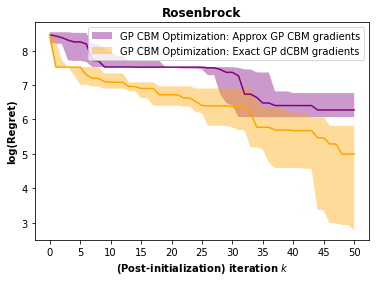

In [128]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Purple')
plt.plot(median_exact, color = 'Orange')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Purple', alpha=0.4, label='GP CBM Optimization: Approx GP CBM gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Orange', alpha=0.4, label='GP CBM Optimization: Exact GP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(0, count, 5))
plt.show() #visualise!

In [129]:
time_approx, time_exact


(1790.5186195373535, 9619.81345129013)

In [130]:
exact51_results, exact51_results[19:20].index[0]


(           0
 8   6.770567
 17  6.494436
 0   6.013732
 6   5.969801
 10  5.817183
 13  5.584363
 18  5.516180
 11  5.511155
 9   5.254867
 14  4.994363
 15  3.811356
 16  3.359558
 3   2.983930
 2   2.932690
 19  2.791180
 7   2.567650
 5   2.337115
 4   2.169160
 1   2.064262
 12  1.623822, 12)

In [131]:
str_exact = str(exact51_results[19:20].index[0]+1)
str_exact


'13'

In [132]:
eval_exactMinIQR_vsCorrApproxExperiment = eval('approx_' + str_exact)
eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc = eval_exactMinIQR_vsCorrApproxExperiment.history[eval_exactMinIQR_vsCorrApproxExperiment.history.index(eval_exactMinIQR_vsCorrApproxExperiment.tau)-1]
eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret = np.log(-eval_exactMinIQR_vsCorrApproxExperiment.tau + y_global_orig)

eval_exactMinIQR_vsCorrApproxExperiment.tau, eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc, eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret


(-185.99917172797404, -185.99917172797404, 5.225742220627878)

In [133]:
### Final iteration: best "approx" experiment results (as above)

np.random.seed(int(str_exact))
eval_exactMinIQR_vsCorrApproxExperiment.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.13746907 -1.07503116  1.32824487  1.90770872  1.93577416]	 -861.6633106396614	 -185.99917172797404	    
init	 [-0.19067188  0.44663793  1.1285566   0.58004826  0.90938667]	 -185.99917172797404	 -185.99917172797404	    
init	 [-1.9044904  -0.82555097 -1.80833283  1.46252162 -0.5207899 ]	 -3656.563030891297	 -185.99917172797404	    
init	 [ 0.73665721 -0.99827733 -0.62430734 -2.00944529 -0.58026483]	 -3224.263616417716	 -185.99917172797404	    
init	 [ 1.83948977 -1.15548566 -0.73977296  1.71119569 -1.91732258]	 -4983.227555400366	 -185.99917172797404	    
1  	 [-2.048  2.048  2.048 -2.048 -2.048]	 -8735.373233766399	 -185.99917172797404	 -2.4452863231931783
2  	 [-2.048  2.048 -2.048 -2.048  2.048]	 -8743.5652337664	 -185.99917172797404	 -2.4429131642283375
3  	 [ 2.048  2.048 -2.048  2.048  2.048]	 -5291.207396966399	 -185.99917172797404	 -2.4373145053221794
4  	 [-2.048 -2.048  2.048 -2.048  2.

In [134]:
eval_exactMinIQR_vsCorrApproxExperiment.x_best, np.round(eval_exactMinIQR_vsCorrApproxExperiment.f_best, 2), eval_exactMinIQR_vsCorrApproxExperiment.best, eval_exactMinIQR_vsCorrApproxExperiment.x_best[np.argmin(eval_exactMinIQR_vsCorrApproxExperiment.f_best)] #### i.e. minAcqFunc returned


(array([[ 2.048     , -2.048     ,  2.048     ,  2.048     , -2.048     ],
        [-0.17282601,  0.08672474, -2.048     , -0.27960547, -2.048     ],
        [-0.19763748, -2.048     ,  0.13859352, -0.12682088, -2.048     ],
        [-0.03616158,  0.13972988,  2.048     , -2.048     ,  2.048     ],
        [ 0.23183666,  1.20251276, -2.048     , -2.048     , -0.1838632 ],
        [ 0.01443341, -1.05196337,  2.048     , -2.048     ,  0.1366881 ],
        [ 2.048     ,  2.048     ,  2.048     ,  2.048     , -2.048     ],
        [ 2.048     , -2.048     ,  2.048     ,  2.048     ,  2.048     ],
        [ 0.29372669, -0.36766791, -0.18884455,  0.71951789,  2.048     ],
        [-0.9976189 ,  0.45225453,  0.17002361,  2.048     ,  0.37267085],
        [ 0.29372505, -0.36766933, -0.18884411,  0.71951275,  2.048     ],
        [ 0.35051413,  2.048     , -0.71231739, -2.048     , -0.11204875],
        [-0.72100035,  2.048     ,  2.048     ,  2.048     ,  0.24996158],
        [-0.72100073,  2.

In [135]:
eval_exactMinIQR = eval('exact_' + str_exact)
eval_exactMinIQR_minAcqFunc = eval_exactMinIQR.history[eval_exactMinIQR.history.index(eval_exactMinIQR.tau)-1]
eval_exactMinIQR_simpleRegret  = np.log(-eval_exactMinIQR.tau + y_global_orig)

eval_exactMinIQR.tau, eval_exactMinIQR_minAcqFunc, eval_exactMinIQR_simpleRegret


(-5.072440257624261, 46.10425113127688, 1.6238220149499558)

In [136]:
### Final iteration: best "exact" experiment results (as above)

np.random.seed(int(str_exact))
eval_exactMinIQR.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.13746907 -1.07503116  1.32824487  1.90770872  1.93577416]	 -861.6633106396614	 -185.99917172797404	    
init	 [-0.19067188  0.44663793  1.1285566   0.58004826  0.90938667]	 -185.99917172797404	 -185.99917172797404	    
init	 [-1.9044904  -0.82555097 -1.80833283  1.46252162 -0.5207899 ]	 -3656.563030891297	 -185.99917172797404	    
init	 [ 0.73665721 -0.99827733 -0.62430734 -2.00944529 -0.58026483]	 -3224.263616417716	 -185.99917172797404	    
init	 [ 1.83948977 -1.15548566 -0.73977296  1.71119569 -1.91732258]	 -4983.227555400366	 -185.99917172797404	    
1  	 [2.048 2.048 2.048 2.048 2.048]	 -1847.0415601664	 -185.99917172797404	 -0.5813119873004793
2  	 [-1.85102721 -1.54712675  1.76693766 -0.58384431 -1.11921837]	 -4117.048928067577	 -185.99917172797404	 -1.1704861485723184
3  	 [-1.60374821  1.63980944 -1.4385986  -1.35155518  0.5009429 ]	 -3155.4217916515117	 -185.99917172797404	 -0.43761910

In [137]:
eval_exactMinIQR.x_best, np.round(eval_exactMinIQR.f_best, 2), eval_exactMinIQR.best, eval_exactMinIQR.x_best[np.argmin(eval_exactMinIQR.f_best)] #### i.e. minAcqFunc returned


(array([[-0.51912046,  0.23142552, -0.45794285,  0.47065247,  0.39691188],
        [-0.09791085,  0.77935835,  0.20863504, -0.34142342, -0.06473327],
        [ 0.48048339, -0.39842065,  1.71541734,  1.37423112, -0.02429685],
        [-1.09577927, -1.25751963, -1.20509746, -2.0158195 ,  0.71640315],
        [-0.54217808, -0.27364251, -1.55671385, -1.77058932,  1.06781153],
        [-0.37863968, -0.48539097,  1.59264733,  0.04684933,  0.88593879],
        [-0.39160763,  0.23011134, -0.61883028, -1.62445872, -1.41334349],
        [-1.01987508,  1.22728894, -0.57154166,  1.84069751, -0.14984445],
        [-0.31519805,  0.07045586,  0.43422613, -0.57674112,  1.82217832],
        [-0.76704034,  0.56032668,  0.42683327,  0.4467344 , -0.61842165],
        [-1.31334768, -0.84598427, -1.67506916, -1.34100568,  2.01490852],
        [-1.90448367,  0.21481851, -1.1777358 , -1.992746  , -0.54570752],
        [-1.92145921,  0.47204059, -0.09058103, -0.18227231,  1.26789146],
        [ 0.95090594,  1.

In [138]:
eval_exactMinIQR.tau > eval_exactMinIQR_vsCorrApproxExperiment.tau # Exact gradients' model: y-value is greater

True

In [139]:
eval_exactMinIQR_minAcqFunc > eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc # Exact gradients' model: best AcqFunc is greater


True

In [140]:
eval_exactMinIQR_simpleRegret < eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret # Exact gradients' model: simple regret's natural log is lower


True

In [141]:
eval_exactMinIQR_minAcqFunc, eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc, eval_exactMinIQR_minAcqFunc/eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc


(46.10425113127688, -185.99917172797404, -0.24787342170912938)

In [142]:
### MinAcqFunc Comparison: Approximate Gradients

approx_1minAcqFunc = approx_1.history[:-1][1::2]
approx_2minAcqFunc = approx_2.history[:-1][1::2]
approx_3minAcqFunc = approx_3.history[:-1][1::2]
approx_4minAcqFunc = approx_4.history[:-1][1::2]
approx_5minAcqFunc = approx_5.history[:-1][1::2]
approx_6minAcqFunc = approx_6.history[:-1][1::2]
approx_7minAcqFunc = approx_7.history[:-1][1::2]
approx_8minAcqFunc = approx_8.history[:-1][1::2]
approx_9minAcqFunc = approx_9.history[:-1][1::2]
approx_10minAcqFunc = approx_10.history[:-1][1::2]
approx_11minAcqFunc = approx_11.history[:-1][1::2]
approx_12minAcqFunc = approx_12.history[:-1][1::2]
approx_13minAcqFunc = approx_13.history[:-1][1::2]
approx_14minAcqFunc = approx_14.history[:-1][1::2]
approx_15minAcqFunc = approx_15.history[:-1][1::2]
approx_16minAcqFunc = approx_16.history[:-1][1::2]
approx_17minAcqFunc = approx_17.history[:-1][1::2]
approx_18minAcqFunc = approx_18.history[:-1][1::2]
approx_19minAcqFunc = approx_19.history[:-1][1::2]
approx_20minAcqFunc = approx_20.history[:-1][1::2]


In [143]:
### MinAcqFunc Comparison: Exact Gradients

exact_1minAcqFunc = exact_1.history[:-1][1::2]
exact_2minAcqFunc = exact_2.history[:-1][1::2]
exact_3minAcqFunc = exact_3.history[:-1][1::2]
exact_4minAcqFunc = exact_4.history[:-1][1::2]
exact_5minAcqFunc = exact_5.history[:-1][1::2]
exact_6minAcqFunc = exact_6.history[:-1][1::2]
exact_7minAcqFunc = exact_7.history[:-1][1::2]
exact_8minAcqFunc = exact_8.history[:-1][1::2]
exact_9minAcqFunc = exact_9.history[:-1][1::2]
exact_10minAcqFunc = exact_10.history[:-1][1::2]
exact_11minAcqFunc = exact_11.history[:-1][1::2]
exact_12minAcqFunc = exact_12.history[:-1][1::2]
exact_13minAcqFunc = exact_13.history[:-1][1::2]
exact_14minAcqFunc = exact_14.history[:-1][1::2]
exact_15minAcqFunc = exact_15.history[:-1][1::2]
exact_16minAcqFunc = exact_16.history[:-1][1::2]
exact_17minAcqFunc = exact_17.history[:-1][1::2]
exact_18minAcqFunc = exact_18.history[:-1][1::2]
exact_19minAcqFunc = exact_19.history[:-1][1::2]
exact_20minAcqFunc = exact_20.history[:-1][1::2]


In [144]:
### MinAcqFunc Comparison: Experiment 1

minAcqFuncApprox1 = np.mean(approx_1minAcqFunc)
minAcqFuncExact1 = np.mean(exact_1minAcqFunc)
ratio1 = minAcqFuncApprox1/minAcqFuncExact1
approx_1.tau, exact_1.tau, minAcqFuncApprox1, minAcqFuncExact1, ratio1


(-765.7749932296757,
 -409.00688446910675,
 64.93151486134268,
 169.09264638970959,
 0.38399963716751073)

In [145]:
### MinAcqFunc Comparison: Experiment 2

minAcqFuncApprox2 = np.mean(approx_2minAcqFunc)
minAcqFuncExact2 = np.mean(exact_2minAcqFunc)
ratio2 = minAcqFuncApprox2/minAcqFuncExact2
approx_2.tau, exact_2.tau, minAcqFuncApprox2, minAcqFuncExact2, ratio2


(-386.2098603720783,
 -7.879480017524095,
 58.86342230205047,
 143.48519997391796,
 0.41024037540283165)

In [146]:
### MinAcqFunc Comparison: Experiment 3

minAcqFuncApprox3 = np.mean(approx_3minAcqFunc)
minAcqFuncExact3 = np.mean(exact_3minAcqFunc)
ratio3 = minAcqFuncApprox3/minAcqFuncExact3
approx_3.tau, exact_3.tau, minAcqFuncApprox3, minAcqFuncExact3, ratio3


(-434.18325270966665,
 -18.778068238979802,
 52.53950126746324,
 140.79494162857512,
 0.3731632731953209)

In [147]:
### MinAcqFunc Comparison: Experiment 4

minAcqFuncApprox4 = np.mean(approx_4minAcqFunc)
minAcqFuncExact4 = np.mean(exact_4minAcqFunc)
ratio4 = minAcqFuncApprox4/minAcqFuncExact4
approx_4.tau, exact_4.tau, minAcqFuncApprox4, minAcqFuncExact4, ratio4


(-651.4075523819531,
 -19.76534722834048,
 81.55432740266663,
 113.6080805541469,
 0.717856749316321)

In [148]:
### MinAcqFunc Comparison: Experiment 5

minAcqFuncApprox5 = np.mean(approx_5minAcqFunc)
minAcqFuncExact5 = np.mean(exact_5minAcqFunc)
ratio5 = minAcqFuncApprox5/minAcqFuncExact5
approx_5.tau, exact_5.tau, minAcqFuncApprox5, minAcqFuncExact5, ratio5


(-249.97815145665106,
 -8.750928189151526,
 58.293223155774655,
 90.9816413728522,
 0.6407141295339241)

In [149]:
### MinAcqFunc Comparison: Experiment 6

minAcqFuncApprox6 = np.mean(approx_6minAcqFunc)
minAcqFuncExact6 = np.mean(exact_6minAcqFunc)
ratio6 = minAcqFuncApprox6/minAcqFuncExact6
approx_6.tau, exact_6.tau, minAcqFuncApprox6, minAcqFuncExact6, ratio6


(-79.69342767466901,
 -10.3513285362379,
 57.316373681565665,
 57.81391325109911,
 0.991394120522987)

In [150]:
### MinAcqFunc Comparison: Experiment 7

minAcqFuncApprox7 = np.mean(approx_7minAcqFunc)
minAcqFuncExact7 = np.mean(exact_7minAcqFunc)
ratio7 = minAcqFuncApprox7/minAcqFuncExact7
approx_7.tau, exact_7.tau, minAcqFuncApprox7, minAcqFuncExact7, ratio7


(-800.4654116124435,
 -391.4278551335964,
 62.50170291150248,
 175.8531701661082,
 0.35541982468933786)

In [151]:
### MinAcqFunc Comparison: Experiment 8

minAcqFuncApprox8 = np.mean(approx_8minAcqFunc)
minAcqFuncExact8 = np.mean(exact_8minAcqFunc)
ratio8 = minAcqFuncApprox8/minAcqFuncExact8
approx_8.tau, exact_8.tau, minAcqFuncApprox8, minAcqFuncExact8, ratio8


(-124.94179932476796,
 -13.035151935793053,
 67.56204281213995,
 105.37222101138674,
 0.6411750854605129)

In [152]:
### MinAcqFunc Comparison: Experiment 9

minAcqFuncApprox9 = np.mean(approx_9minAcqFunc)
minAcqFuncExact9 = np.mean(exact_9minAcqFunc)
ratio9 = minAcqFuncApprox9/minAcqFuncExact9
approx_9.tau, exact_9.tau, minAcqFuncApprox9, minAcqFuncExact9, ratio9


(-698.816697067542,
 -698.816697067542,
 65.51981918033775,
 174.499940304972,
 0.37547187159966555)

In [153]:
### MinAcqFunc Comparison: Experiment 10

minAcqFuncApprox10 = np.mean(approx_10minAcqFunc)
minAcqFuncExact10 = np.mean(exact_10minAcqFunc)
ratio10 = minAcqFuncApprox10/minAcqFuncExact10
approx_10.tau, exact_10.tau, minAcqFuncApprox10, minAcqFuncExact10, ratio10


(-604.8405546092181,
 -191.49597259487953,
 62.58509840116162,
 171.9834277686616,
 0.3639019131851826)

In [154]:
### MinAcqFunc Comparison: Experiment 11

minAcqFuncApprox11 = np.mean(approx_11minAcqFunc)
minAcqFuncExact11 = np.mean(exact_11minAcqFunc)
ratio11 = minAcqFuncApprox11/minAcqFuncExact11
approx_11.tau, exact_11.tau, minAcqFuncApprox11, minAcqFuncExact11, ratio11


(-282.0124064457454,
 -336.02423398941323,
 62.76239806462295,
 174.46940121298834,
 0.3597329825646849)

In [155]:
### MinAcqFunc Comparison: Experiment 12

minAcqFuncApprox12 = np.mean(approx_12minAcqFunc)
minAcqFuncExact12 = np.mean(exact_12minAcqFunc)
ratio12 = minAcqFuncApprox12/minAcqFuncExact12
approx_12.tau, exact_12.tau, minAcqFuncApprox12, minAcqFuncExact12, ratio12


(-430.47006432762635,
 -247.43683479431684,
 69.35689778684082,
 160.4049595029077,
 0.43238624293024785)

In [156]:
### MinAcqFunc Comparison: Experiment 13

minAcqFuncApprox13 = np.mean(approx_13minAcqFunc)
minAcqFuncExact13 = np.mean(exact_13minAcqFunc)
ratio13 = minAcqFuncApprox13/minAcqFuncExact13
approx_13.tau, exact_13.tau, minAcqFuncApprox13, minAcqFuncExact13, ratio13


(-185.99917172797404,
 -5.072440257624261,
 -61.16740632375462,
 -10.934895769352934,
 5.593780463384715)

In [157]:
### MinAcqFunc Comparison: Experiment 14

minAcqFuncApprox14 = np.mean(approx_14minAcqFunc)
minAcqFuncExact14 = np.mean(exact_14minAcqFunc)
ratio14 = minAcqFuncApprox14/minAcqFuncExact14
approx_14.tau, exact_14.tau, minAcqFuncApprox14, minAcqFuncExact14, ratio14


(-434.7109932091103,
 -266.2306529214269,
 71.18942485734927,
 175.85522059593941,
 0.40481837625350015)

In [158]:
### MinAcqFunc Comparison: Experiment 15

minAcqFuncApprox15 = np.mean(approx_15minAcqFunc)
minAcqFuncExact15 = np.mean(exact_15minAcqFunc)
ratio15 = minAcqFuncApprox15/minAcqFuncExact15
approx_15.tau, exact_15.tau, minAcqFuncApprox15, minAcqFuncExact15, ratio15


(-432.19792591887006,
 -147.57886997076608,
 76.91366725084443,
 190.5951037055195,
 0.40354482227245725)

In [159]:
### MinAcqFunc Comparison: Experiment 16

minAcqFuncApprox16 = np.mean(approx_16minAcqFunc)
minAcqFuncExact16 = np.mean(exact_16minAcqFunc)
ratio16 = minAcqFuncApprox16/minAcqFuncExact16
approx_16.tau, exact_16.tau, minAcqFuncApprox16, minAcqFuncExact16, ratio16


(-464.3305193395537,
 -45.21171260868515,
 65.08349311269515,
 162.37875321774106,
 0.40081286389372467)

In [160]:
### MinAcqFunc Comparison: Experiment 17

minAcqFuncApprox17 = np.mean(approx_17minAcqFunc)
minAcqFuncExact17 = np.mean(exact_17minAcqFunc)
ratio17 = minAcqFuncApprox17/minAcqFuncExact17
approx_17.tau, exact_17.tau, minAcqFuncApprox17, minAcqFuncExact17, ratio17


(-102.96374117512207,
 -28.77647329486857,
 50.76010631609054,
 111.07817180460563,
 0.456976429224827)

In [161]:
### MinAcqFunc Comparison: Experiment 18

minAcqFuncApprox18 = np.mean(approx_18minAcqFunc)
minAcqFuncExact18 = np.mean(exact_18minAcqFunc)
ratio18 = minAcqFuncApprox18/minAcqFuncExact18
approx_18.tau, exact_18.tau, minAcqFuncApprox18, minAcqFuncExact18, ratio18


(-532.320543691963,
 -661.4511522130688,
 66.76721219821147,
 173.6846943777705,
 0.3844162114422723)

In [162]:
### MinAcqFunc Comparison: Experiment 19

minAcqFuncApprox19 = np.mean(approx_19minAcqFunc)
minAcqFuncExact19 = np.mean(exact_19minAcqFunc)
ratio19 = minAcqFuncApprox19/minAcqFuncExact19
approx_19.tau, exact_19.tau, minAcqFuncApprox19, minAcqFuncExact19, ratio19


(-626.7075296149584,
 -248.6833742097439,
 56.31225958237708,
 168.55008444589748,
 0.3340980799119838)

In [163]:
### MinAcqFunc Comparison: Experiment 20

minAcqFuncApprox20 = np.mean(approx_20minAcqFunc)
minAcqFuncExact20 = np.mean(exact_20minAcqFunc)
ratio20 = minAcqFuncApprox20/minAcqFuncExact20
approx_20.tau, exact_20.tau, minAcqFuncApprox20, minAcqFuncExact20, ratio20


(-104.43212504231103,
 -16.300236280579806,
 63.55688717488478,
 120.05833808316187,
 0.5293833663669429)

In [164]:
num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ApproxTau = [approx_1.tau,approx_2.tau,approx_3.tau,approx_4.tau,approx_5.tau,approx_6.tau,approx_7.tau,approx_8.tau,approx_9.tau,approx_10.tau,approx_11.tau,approx_12.tau,approx_13.tau,approx_14.tau,approx_15.tau,approx_16.tau,approx_17.tau,approx_18.tau,approx_19.tau,approx_20.tau]
ExactTau = [exact_1.tau,exact_2.tau,exact_3.tau,exact_4.tau,exact_5.tau,exact_6.tau,exact_7.tau,exact_8.tau,exact_9.tau,exact_10.tau,exact_11.tau,exact_12.tau,exact_13.tau,exact_14.tau,exact_15.tau,exact_16.tau,exact_17.tau,exact_18.tau,exact_19.tau,exact_20.tau]
AvgMinAcqFuncExact = [minAcqFuncExact1,minAcqFuncExact2,minAcqFuncExact3,minAcqFuncExact4,minAcqFuncExact5,minAcqFuncExact6,minAcqFuncExact7,minAcqFuncExact8,minAcqFuncExact9,minAcqFuncExact10,minAcqFuncExact11,minAcqFuncExact12,minAcqFuncExact13,minAcqFuncExact14,minAcqFuncExact15,minAcqFuncExact16,minAcqFuncExact17,minAcqFuncExact18,minAcqFuncExact19,minAcqFuncExact20]
AvgMinAcqFuncApprox = [minAcqFuncApprox1,minAcqFuncApprox2,minAcqFuncApprox3,minAcqFuncApprox4,minAcqFuncApprox5,minAcqFuncApprox6,minAcqFuncApprox7,minAcqFuncApprox8,minAcqFuncApprox9,minAcqFuncApprox10,minAcqFuncApprox11,minAcqFuncApprox12,minAcqFuncApprox13,minAcqFuncApprox14,minAcqFuncApprox15,minAcqFuncApprox16,minAcqFuncApprox17,minAcqFuncApprox18,minAcqFuncApprox19,minAcqFuncApprox20]
ratio = [ratio1,ratio2,ratio3,ratio4,ratio5,ratio6,ratio7,ratio8,ratio9,ratio10,ratio11,ratio12,ratio13,ratio14,ratio15,ratio16,ratio17,ratio18,ratio19,ratio20]


In [165]:
def greaterThan(a, b):
  lis =[]
  #convert to list
  a = list(a)
  b = list(b)
  c = "Yes"
  d = "No"
  e = "equal"
  for first, first_te in zip(a, b):
      if first < first_te:
          lis.append(d)
      elif first > first_te:
          lis.append(c)
      else:
          lis.append(e)
  return lis

greaterAcqFunc = greaterThan(AvgMinAcqFuncExact, AvgMinAcqFuncApprox)


In [166]:
def greaterRatio(a):
  lis =[]
  #convert to list
  a = list(a)
  b = "Yes"
  c = "No"
  d = "equal"
  for first, in zip(a):
      if first < 1:
          lis.append(c)
      elif first > 1:
          lis.append(b)
      else:
          lis.append(d)
  return lis

greaterRatio = greaterRatio(ratio)


In [167]:
df = pd.DataFrame(dict(Experiment=num,
                  ExactTau=ExactTau,
                  ApproxTau=ApproxTau,
                  AvgMinAcqFuncExact=AvgMinAcqFuncExact,
                  GreaterAcqFunc = greaterAcqFunc,
                  AvgMinAcqFuncApprox=AvgMinAcqFuncApprox,
                  Ratio = ratio,
                  GreaterRatio = greaterRatio))
df.sort_values(by=['ExactTau'], inplace=True, ascending=False)
print(df.to_latex(index=False))


\begin{tabular}{rrrrlrrl}
\toprule
 Experiment &    ExactTau &   ApproxTau &  AvgMinAcqFuncExact & GreaterAcqFunc &  AvgMinAcqFuncApprox &    Ratio & GreaterRatio \\
\midrule
         13 &   -5.072440 & -185.999172 &          -10.934896 &            Yes &           -61.167406 & 5.593780 &          Yes \\
          2 &   -7.879480 & -386.209860 &          143.485200 &            Yes &            58.863422 & 0.410240 &           No \\
          5 &   -8.750928 & -249.978151 &           90.981641 &            Yes &            58.293223 & 0.640714 &           No \\
          6 &  -10.351329 &  -79.693428 &           57.813913 &            Yes &            57.316374 & 0.991394 &           No \\
          8 &  -13.035152 & -124.941799 &          105.372221 &            Yes &            67.562043 & 0.641175 &           No \\
         20 &  -16.300236 & -104.432125 &          120.058338 &            Yes &            63.556887 & 0.529383 &           No \\
          3 &  -18.778068 & -434.183253

In [168]:
avg_list = ['ExactTau', 'ApproxTau', 'AvgMinAcqFuncExact','AvgMinAcqFuncApprox']
avg = df[avg_list].mean()
avg.name = 'Average'
df = df.append(avg.transpose())
df.fillna(value='', inplace=True)
df


,Experiment,ExactTau,ApproxTau,AvgMinAcqFuncExact,GreaterAcqFunc,AvgMinAcqFuncApprox,Ratio,GreaterRatio
12,13.0,-5.072440,-185.999172,-10.934896,Yes,-61.167406,5.59378,Yes
1,2.0,-7.879480,-386.209860,143.485200,Yes,58.863422,0.41024,No
4,5.0,-8.750928,-249.978151,90.981641,Yes,58.293223,0.640714,No
5,6.0,-10.351329,-79.693428,57.813913,Yes,57.316374,0.991394,No
7,8.0,-13.035152,-124.941799,105.372221,Yes,67.562043,0.641175,No
19,20.0,-16.300236,-104.432125,120.058338,Yes,63.556887,0.529383,No
2,3.0,-18.778068,-434.183253,140.794942,Yes,52.539501,0.373163,No
3,4.0,-19.765347,-651.407552,113.608081,Yes,81.554327,0.717857,No
16,17.0,-28.776473,-102.963741,111.078172,Yes,50.760106,0.456976,No
15,16.0,-45.211713,-464.330519,162.378753,Yes,65.083493,0.400813,No


In [169]:
print('Ratio of Average ExactTau to Average ApproxTau:', np.round(avg[1]/avg[0], 5))
print('Ratio of Average AvgMinAcqFuncExact to Average AvgMinAcqFuncApprox:', np.round(avg[3]/avg[2], 5))
print('Number of experiments where AvgMinAcqFuncExact exceeds AvgMinAcqFuncApprox:', df['GreaterAcqFunc'].value_counts()['Yes'])
print('Number of experiments where Ratio exceeds 1.0:', df['GreaterRatio'].value_counts()['Yes'])


Ratio of Average ExactTau to Average ApproxTau: 2.22489
Ratio of Average AvgMinAcqFuncExact to Average AvgMinAcqFuncApprox: 0.41637
Number of experiments where AvgMinAcqFuncExact exceeds AvgMinAcqFuncApprox: 20
Number of experiments where Ratio exceeds 1.0: 1
